# Pressor Distributions
- Ruoyi Jiang
- July 19, 2019
- Evaluation of the different pressor combinations used in MIMIC

In [9]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(fasttime)

# RR analysis
library(epitools)

# ROC (and plotting)
library(boot)
library(pROC)

# imputation
library(randomForest)

# VIF analysis
library(car)

library(glmnet)
library(pls)

library(lme4)

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 


In [10]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-apple-darwin18.5.0 (64-bit)
Running under: macOS Mojave 10.14.3

Matrix products: default
BLAS/LAPACK: /usr/local/Cellar/openblas/0.3.6_1/lib/libopenblasp-r0.3.6.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] lme4_1.1-21         pls_2.7-1           glmnet_2.0-18      
 [4] foreach_1.4.7       Matrix_1.2-17       car_3.0-3          
 [7] carData_3.0-2       randomForest_4.6-14 pROC_1.15.3        
[10] boot_1.3-22         epitools_0.5-10     fasttime_1.0-2     
[13] ggplot2_3.2.0       tidyr_0.8.3         dplyr_0.8.1        

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3      tidyselect_0.2.5  repr_1.0.1        purrr_0.3.3      
 [5] splines_3.6.0     haven_2.1.1       lattice_0.20-38   colorspace_1.4-1 
 [9] vctrs_0.2.0       htmltools_0.4.0   base64enc_0.1-3   rlan

In [5]:
### Plotting base_theme
base_theme <- function(){ theme_bw() + 
            theme(text=element_text(size=8)) +
            theme(plot.title=element_text(size=8)) +
            theme(plot.background=element_blank(),
                  panel.grid.major=element_blank(), 
                  panel.grid.minor=element_blank()) +
            theme(strip.background=element_blank(),
                  strip.text=element_text(size=7, face='bold')) +
            theme(axis.title=element_text(size=8, vjust=0.25),
                  axis.text.x=element_text(size=8, vjust=0.5, hjust=0.5),
                  axis.text.y=element_text(size=8)) +
            theme(legend.text=element_text(size=7),
                  legend.title=element_text(size=7),
                  legend.key.height=grid::unit(10, "points"), 
                  legend.key.width=grid::unit(10, "points"))}

### Load data and take quick peek at select "pressors"  (e.g. vent and central line)

In [6]:
pressors_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/pressors.csv')

In [7]:
dim(pressors_df)

[1] 227645     11

In [8]:
pressors_df %>%
    group_by(pressor) %>%
    summarize(COUNT = n())

pressor,COUNT
<fct>,<int>
adenosinedurations,160
arterial_line_durations,30424
central_line_durations,38211
crrtdurations,5918
dobutaminedurations,1792
dopaminedurations,6524
epinephrinedurations,3126
isupreldurations,24
milrinonedurations,3600


In [9]:
central_line_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/central_line_durations_corrected.csv')

### Available pressor (and other infusions) choices
- Make choices
- Quick check of dataset balancing

In [74]:
pressor_choices <- c("norepinephrinedurations", "dopaminedurations", 
                     "phenylephrinedurations", "vasopressindurations", 'epinephrinedurations')

In [75]:
FANCY_PRESSOR_ORDER <- c("Norepinephrine", "Dopamine", "Phenylephrine", "Vasopressin", "Epinephrine")

In [76]:
FANCY_PRESSOR_DICT <- c(
'dopaminedurations' = 'Dopamine',
'norepinephrinedurations' = 'Norepinephrine',  
'phenylephrinedurations' = 'Phenylephrine',
"vasopressindurations" = "Vasopressin",
'epinephrinedurations' = "Epinephrine"
)

In [70]:
PLOT_DIR <- "~/Google Drive/vasopressors/figures_v3"

In [14]:
# pressors_df %>%
#     filter(pressor %in% pressor_choices)  %>%
#     filter((pressor == 'phenylephrinedurations' & duration_hours > 0.5) |
#            (pressor == 'epinephrinedurations' & duration_hours > 0.5) |
#            !(pressor %in% c('phenylephrinedurations', 'phenylephrinedurations'))
#           ) %>%
#     mutate(MORETHAN24HOURS = duration_hours > 24) %>%
#     group_by(MORETHAN24HOURS, pressor) %>% 
#     summarize(COUNT = n())

### Join with icustay metadata (pressors_df + lengthstay_df -> input_df)
### Also remove <0.5 hr epinephrine and phenyelphrine doses

In [15]:
lengthstay_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/length_stay.csv') %>%
    rename(icustarttime = START, icuendtime = END)

In [16]:
# filter by pressor and left join with lengthstay_df
input_df <- pressors_df %>%
    filter(pressor %in% pressor_choices)  %>%
    filter((pressor == 'phenylephrinedurations' & duration_hours > 0.5) |
           (pressor == 'epinephrinedurations' & duration_hours > 0.5) |
           !(pressor %in% c('phenylephrinedurations', 'epinephrinedurations'))
          ) %>%
    left_join(lengthstay_df, by = "icustay_id") %>%
    mutate(starttime = fastPOSIXct(starttime), endtime = fastPOSIXct(endtime), 
           icustarttime = fastPOSIXct(icustarttime), icuendtime = fastPOSIXct(icuendtime))

# Filters

#### Collapse pressor courses based on length of intervening time (<24 hrs)
- Any two courses with less than intervening 24 hours will be collapsed into a single course within an icustay

In [17]:
max_intervening_hrs <- 24

# find the intervening time between courses (endtime of next course - endtime of course - duration of course)
# then determine if that length of time is >24 or <24 and mark it with a 0 if true, else a 1
# use a cumsum to create a new id separating courses that are separated by more than >24

input_df <- input_df %>%
        group_by(icustay_id) %>%
        arrange(starttime) %>%
        mutate(intervening_hours = difftime(endtime, lag(endtime), units="hours") - duration_hours) %>%
        rowwise() %>%
        mutate(increasing = if(intervening_hours < max_intervening_hrs | is.na(intervening_hours)){0}else(1)) %>%
        ungroup() %>%
        group_by(icustay_id) %>%
        mutate(continuous_course = cumsum(increasing)) %>% select(-intervening_hours, -increasing)

In [18]:
# max_intervening_hrs <- 24

# # find the intervening time between courses (endtime of next course - endtime of course - duration of course)
# # then determine if that length of time is >24 or <24 and mark it with a 0 if true, else a 1
# # use a cumsum to create a new id separating courses that are separated by more than >24
# input_list <- list()
# for(pressor_choice in pressor_choices){
#     input_list[[pressor_choice]] <- input_df %>%
#         filter(pressor == pressor_choice) %>%
#         group_by(icustay_id) %>%
#         mutate(intervening_hours = difftime(endtime, lag(endtime), units="hours") - duration_hours) %>%
#         rowwise() %>%
#         mutate(increasing = if(intervening_hours < max_intervening_hrs | is.na(intervening_hours)){0}else(1)) %>%
#         ungroup() %>%
#         group_by(icustay_id) %>%
#         mutate(continuous_course = cumsum(increasing)) %>% select(-intervening_hours, -increasing)
#     cat(pressor_choice, '\n')
# }

In [19]:
# input_df <- bind_rows(input_list, .id="pressor_choice")

- the combination of **continuous course** and **icustay_id** (e.g. 200024, 0 for first row) now defines each pressor course

- assign boolean assessments after <24 hour intervals between pressors are removed
    1. more or less than 24 hours of pressor duration?
    2. is this the first pressor course?
    3. are pressors administered <1 hr of the icustay?

In [20]:
# 1. more or less than 24 hours?
input_df <- input_df %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(MORETHAN24HOURS = sum(duration_hours) > 24, 
           STATUS = if(sum(duration_hours) > 24){"MORETHAN24HOURS"}
           else if(sum(duration_hours) <= 24 & sum(duration_hours) > 6){"LESSTHAN24HOURS"}
           else if(sum(duration_hours) <= 6){"LESSTHAN6HOURS"}
               )

In [21]:
# 2. first pressor course? (groupby icustay, filter min starttime == starttime)
input_df <- input_df %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(coursestarttime = min(starttime)) %>%
    group_by(icustay_id) %>%
    mutate(FIRSTCOURSE = min(coursestarttime) == coursestarttime)

In [22]:
# 3. pressors within 1 hr of icustay_id? (groupby icustay, filter max starttime - unique icustarttime > 1)
input_df <- input_df %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(coursestarttime = min(starttime)) %>%
    group_by(icustay_id) %>%
    mutate(LESS1HOUR = difftime(min(coursestarttime), 
                         min(icustarttime)) < 1)

In [19]:
# grouped by icustay_id + continuous_course + separate_course
input_df %>%
    group_by(LESS1HOUR, FIRSTCOURSE, MORETHAN24HOURS) %>%
    summarize(COUNT = n())

LESS1HOUR,FIRSTCOURSE,MORETHAN24HOURS,COUNT
<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,2206
FALSE,FALSE,TRUE,7632
FALSE,TRUE,FALSE,14398
FALSE,TRUE,TRUE,35817
TRUE,FALSE,FALSE,107
TRUE,FALSE,TRUE,266
TRUE,TRUE,FALSE,879
TRUE,TRUE,TRUE,1872
NA,FALSE,FALSE,153


In [20]:
# With filters grouped by icustay_id + continuous_course
input_df %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(LESS1HOUR, FIRSTCOURSE, MORETHAN24HOURS) %>%
    summarize(COUNT = length(unique(course_id)))

LESS1HOUR,FIRSTCOURSE,MORETHAN24HOURS,COUNT
<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,1397
FALSE,FALSE,TRUE,1317
FALSE,TRUE,FALSE,8656
FALSE,TRUE,TRUE,6613
TRUE,FALSE,FALSE,66
TRUE,FALSE,TRUE,61
TRUE,TRUE,FALSE,569
TRUE,TRUE,TRUE,412
NA,FALSE,FALSE,101


### Introduce other predictor values for each course (like RACE, Diagnosis type) -> nonvitals_predictor_df

In [23]:
races <- c("ASIAN", "BLACK", "HISPANIC", "WHITE", "OTHER")

simplifyRace <- function(ethnicity){
    if(grepl("ASIAN", ethnicity)){return("ASIAN")}
    else if(grepl("BLACK", ethnicity)){return("BLACK")}
    else if(grepl("HISPANIC", ethnicity)){return("HISPANIC")}
    else if(grepl("WHITE", ethnicity)){return("WHITE")}
    else{return("OTHER")}
}

In [24]:
infection_regex <- c('PNEUMONIA', 'INFECTION',  
  'CELULLITIS', 'FASCITIS', 'INFECTED', 'BACTER', 'PNEMONIA', 'ABSCESS', 'NEPHRITIS',
                    'SEPSIS', 'SEPTIC', 'CHOLANGITIS', 'UROSEPSIS')

cardiac_regex <- c('HEART', 'CORONARY', 'VENTRICULAR')

simplifyDiagnosis <- function(diagnosis){
    if(any(sapply(infection_regex, function(x) grepl(x, diagnosis)))){return("INFECTION")}
    else if(any(sapply(cardiac_regex, function(x) grepl(x, diagnosis)))){return("CARDIAC")}
    else{return("OTHER DIAGNOSIS")}
}

In [25]:
icustays_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/icustays.csv')

In [26]:
admissions_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/admissions.csv')

In [27]:
patients_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/patients.csv')

In [28]:
severity_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/sofa.csv') %>% select(icustay_id, sofa) %>%
    left_join(read.csv('~/Projects/Haimovich_Pressors/collection/out/oasis.csv') %>% select(icustay_id, oasis), by = 'icustay_id') %>%
    left_join(read.csv('~/Projects/Haimovich_Pressors/collection/out/qsofa.csv') %>% select(icustay_id, qsofa), by = 'icustay_id')

In [29]:
intub_df <- pressors_df %>%
    filter(pressor == "ventdurations") 

cvc_df <- central_line_df

In [30]:
# 3 mins
nonvitals_predictor_df <- icustays_df %>%
    select(hadm_id, icustay_id, first_careunit, last_careunit) %>%
    left_join(admissions_df, by = 'hadm_id') %>%
    left_join(patients_df, by = 'subject_id') %>%
    left_join(severity_df, by = 'icustay_id') %>%
    mutate(intub = icustay_id %in% intub_df$icustay_id, cvc = icustay_id %in% cvc_df$icustay_id) %>%
    mutate(deathtime = fastPOSIXct(deathtime), admittime = fastPOSIXct(admittime), dob = fastPOSIXct(dob)) %>%
    mutate(age = difftime(admittime, dob, units="weeks")/52.25, 
           age_cohort = as.numeric(round(age, digits = -1))) %>% 
    rowwise() %>%
    mutate(simple_race = simplifyRace(ethnicity)) %>%
    mutate(simple_diagnosis = simplifyDiagnosis(diagnosis))

### Mortality filter
- Remove patients who stopped using pressors because death (merge with pressors_df by icustay_id, filter if pressor course end time == or is close to deathtime)
- Also quantify some unusual cases of death documentation

In [223]:
#NA means the stay did not end in death
#ICUSTAYS where patient was discharged after death? (TRUE)
nonvitals_predictor_df  %>%
    mutate(MORTALITYERROR = difftime(deathtime, dischtime, units = "mins") < 0) %>%
    group_by(MORTALITYERROR) %>%
    summarize(COUNT = n())

Warning message:
“Grouping rowwise data frame strips rowwise nature”

MORTALITYERROR,COUNT
<lgl>,<int>
FALSE,40
TRUE,6422
NA,55070


In [224]:
#NA means the stay did not end in death
#ICUSTAYS where patient was admitted after death? (TRUE)
nonvitals_predictor_df  %>%
    mutate(MORTALITYERROR = difftime(deathtime, admittime, units = "mins") < 0) %>%
    group_by(MORTALITYERROR) %>%
    summarize(COUNT = n())

Warning message:
“Grouping rowwise data frame strips rowwise nature”

MORTALITYERROR,COUNT
<lgl>,<int>
FALSE,6384
TRUE,78
NA,55070


In [225]:
#Examples (admitted after death)
nonvitals_predictor_df  %>%
    filter(difftime(deathtime, admittime, units = "mins") < 0) %>%
    head(5)

hadm_id,icustay_id,first_careunit,last_careunit,X.x,row_id.x,subject_id,admittime,dischtime,deathtime,⋯,expire_flag,sofa,oasis,qsofa,intub,cvc,age,age_cohort,simple_race,simple_diagnosis
<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<dttm>,<fct>,<dttm>,⋯,<int>,<int>,<int>,<int>,<lgl>,<lgl>,<drtn>,<dbl>,<chr>,<chr>
102631,246694,CSRU,CSRU,456,237,181,2153-10-12 05:49:00,2153-10-12 06:29:00,2153-10-12 02:29:00,⋯,1,2,17,0,FALSE,FALSE,65.12757082 weeks,70,WHITE,OTHER DIAGNOSIS
138015,298263,NICU,NICU,1911,1640,1334,2137-09-02 10:43:00,2137-09-02 12:00:00,2137-09-02 08:00:00,⋯,1,10,24,0,TRUE,FALSE,0.00167654 weeks,0,WHITE,OTHER DIAGNOSIS
181430,291798,SICU,SICU,1970,1699,1381,2189-01-02 09:25:00,2189-01-02 12:00:00,2189-01-02 07:00:00,⋯,1,5,54,2,TRUE,FALSE,81.36049404 weeks,80,WHITE,OTHER DIAGNOSIS
187482,213831,MICU,MICU,693,644,516,2197-07-31 16:18:00,2197-07-31 01:10:00,2197-07-30 21:10:00,⋯,1,2,17,0,FALSE,FALSE,70.88679654 weeks,70,OTHER,OTHER DIAGNOSIS
190088,293048,CCU,CCU,3624,3447,2858,2108-09-25 11:29:00,2108-09-25 12:00:00,2108-09-25 08:00:00,⋯,1,12,50,2,TRUE,FALSE,82.42418356 weeks,80,WHITE,OTHER DIAGNOSIS


In [226]:
# Icustays where patients received pressors after death (TRUE)
input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    mutate(STOPMORTALITY = difftime(deathtime, endtime, units = "mins")) %>% 
    group_by(STOPMORTALITY < 0) %>%
    summarize(COUNT = length(unique(icustay_id)))

STOPMORTALITY < 0,COUNT
<lgl>,<int>
FALSE,3439
TRUE,694
NA,13368


### Test out some mortality filters

In [227]:
### if I do not ignore for unusual cases (pressors after death)
input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course, pressor) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = STOPMORTALITY < 5) %>%
    group_by(STOPMORTALITY) %>%
    summarize(COUNT = n())

STOPMORTALITY,COUNT
<lgl>,<int>
FALSE,18873
TRUE,4427
NA,44964


In [228]:
### if I do ignore these unusual cases
input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course, pressor) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = STOPMORTALITY > 0 &  STOPMORTALITY < 5) %>%
    group_by(STOPMORTALITY) %>%
    summarize(COUNT = n())

STOPMORTALITY,COUNT
<lgl>,<int>
FALSE,23033
TRUE,267
NA,44964


### Create filters for mortality: input_df -> input_death_df

In [38]:
# # ignore NAs (patient did not die), or patient death did not correspond to end of pressor course
# # do not remove unusual cases
# input_death_df <- input_df %>%
#     ungroup() %>%
#     left_join(nonvitals_predictor_df, by = "icustay_id") %>%
#     group_by(icustay_id, continuous_course, pressor) %>%
#     mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
#     mutate(STOPMORTALITY = !(!(STOPMORTALITY < 5) | is.na(STOPMORTALITY)))

In [31]:
# ignore NAs (patient did not die), or patient death did not correspond to end of pressor course
# remove unusual cases
input_death_df <- input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = !(!(STOPMORTALITY > 0 &  STOPMORTALITY < 5) | is.na(STOPMORTALITY)))

### Exclude NICU (all NICU was already excluded by pressor usage): : input_death_df -> input_death_df

In [25]:
input_death_df %>%
    mutate(NICUSTAY = first_careunit == "NICU") %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(LESS1HOUR, FIRSTCOURSE, STOPMORTALITY, MORETHAN24HOURS, NICUSTAY) %>%
    summarize(COUNT = length(unique(course_id)))

LESS1HOUR,FIRSTCOURSE,STOPMORTALITY,MORETHAN24HOURS,NICUSTAY,COUNT
<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,FALSE,FALSE,1384
FALSE,FALSE,FALSE,FALSE,TRUE,7
FALSE,FALSE,FALSE,TRUE,FALSE,1330
FALSE,FALSE,FALSE,TRUE,TRUE,19
FALSE,FALSE,TRUE,FALSE,FALSE,1
FALSE,FALSE,TRUE,TRUE,FALSE,7
FALSE,TRUE,FALSE,FALSE,FALSE,8520
FALSE,TRUE,FALSE,FALSE,TRUE,87
FALSE,TRUE,FALSE,TRUE,FALSE,6636


In [33]:
input_death_df <- input_death_df %>%
    filter(first_careunit != "NICU")

### Use filters, clean predictors: input_death_df -> output_df

In [34]:
output_df <- input_death_df %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(course_id) %>%
    mutate(starttime = min(starttime), endtime = max(endtime)) %>%
    filter(!LESS1HOUR, FIRSTCOURSE, !STOPMORTALITY) 

In [35]:
# collapse so each row is a course_id
output_df <- output_df %>%
    group_by(course_id) %>%
    summarize(
            PATIENT = unique(subject_id)[1],
            STATUS = unique(STATUS)[1], 
            MORETHAN24HOURS = unique(MORETHAN24HOURS)[1], 
            simple_diagnosis = unique(simple_diagnosis)[1], 
            simple_race = unique(simple_race)[1], 
            age = unique(age)[1], 
            age_cohort = unique(age_cohort)[1], 
            cvc = unique(cvc)[1],
            intub = unique(intub)[1],
            first_careunit = unique(first_careunit)[1],
            gender = unique(gender)[1],
            icustay_id = unique(icustay_id)[1],
            starttime = min(starttime), 
            endtime = max(endtime),
            pressor = paste(unique(pressor), collapse=","),
            sofa = unique(sofa)[1],
            qsofa = unique(qsofa)[1],
            oasis = unique(oasis)[1],
    ) %>% 
    mutate(duration = difftime(endtime, 
                       starttime, units="hours"))

### If more than 1 pressor is used, MORETHAN24HOURS is TRUE

In [36]:
output_df <- output_df %>%
    rowwise() %>%
    mutate(RESPONSE = MORETHAN24HOURS | grepl(",", pressor))

### Age filter > 18

In [37]:
output_df <- output_df %>%
    filter(age >= 18 | is.na(age))

In [38]:
output_df %>% write.csv("~/Projects/Haimovich_Pressors/collection/out/output.csv")

# Analysis

In [3]:
SIGNIFICANT_COLORS <- c(
"Significant" = '#2F4F4F',
"Not Significant" = '#D3D3D3'
)

In [4]:
output_df <- read.csv("~/Projects/Haimovich_Pressors/collection/out/output.csv")

### For text, description of meta-data

In [5]:
length(unique(output_df$PATIENT))

[1] 13394

In [37]:
length(unique(output_df$icustay_id))

[1] 15014

In [8]:
length(unique(output_df$course_id))

[1] 15014

In [9]:
# minimum age
min(output_df$age, na.rm=TRUE)

[1] 18.22476

In [40]:
output_df %>%
    mutate(MINOR = age < 18) %>%
    group_by(MINOR, first_careunit) %>%
    summarize(COUNT = n()) 

Warning message:
“Grouping rowwise data frame strips rowwise nature”

MINOR,first_careunit,COUNT
<lgl>,<fct>,<int>
FALSE,CCU,1889
FALSE,CSRU,5727
FALSE,MICU,3799
FALSE,SICU,1729
FALSE,TSICU,1231
NA,CCU,134
NA,CSRU,76
NA,MICU,307
NA,SICU,68


In [6]:
dim(output_df)

[1] 15014    22

In [244]:
output_df %>%
    group_by(STATUS) %>%
    summarize(COUNT = n())

Warning message:
“Grouping rowwise data frame strips rowwise nature”

STATUS,COUNT
<chr>,<int>
LESSTHAN24HOURS,5020
LESSTHAN6HOURS,3523
MORETHAN24HOURS,6471


In [245]:
output_df %>%
    group_by(STATUS, pressor) %>%
    summarize(COUNT = length(unique(PATIENT))) %>%
    filter(!grepl(",", pressor))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

STATUS,pressor,COUNT
<chr>,<chr>,<int>
LESSTHAN24HOURS,dopaminedurations,409
LESSTHAN24HOURS,epinephrinedurations,116
LESSTHAN24HOURS,norepinephrinedurations,958
LESSTHAN24HOURS,phenylephrinedurations,2413
LESSTHAN24HOURS,vasopressindurations,19
LESSTHAN6HOURS,dopaminedurations,428
LESSTHAN6HOURS,epinephrinedurations,72
LESSTHAN6HOURS,norepinephrinedurations,700
LESSTHAN6HOURS,phenylephrinedurations,2073


In [13]:
output_df %>%
    group_by(RESPONSE = STATUS == "LESSTHAN6HOURS" & !grepl(",", pressor)) %>%
    summarize(COUNT =n()) %>% 
    mutate(FREQ = COUNT/sum(COUNT))

RESPONSE,COUNT,FREQ
<lgl>,<int>,<dbl>
FALSE,11695,0.7789397
TRUE,3319,0.2210603


In [40]:
output_df %>%
    group_by(RESPONSE = STATUS == "LESSTHAN6HOURS" & !grepl(",", pressor), cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>%
    filter(RESPONSE)

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
TRUE,FALSE,917,0.276288
TRUE,TRUE,2402,0.723712


In [41]:
# Less than 24 hours AND only one vasopressor
output_df %>%
    group_by(RESPONSE = STATUS != "MORETHAN24HOURS" & !grepl(",", pressor)) %>%
    summarize(COUNT = n()) %>% 
    mutate(FREQ = COUNT/sum(COUNT))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,COUNT,FREQ
<lgl>,<int>,<dbl>
FALSE,7721,0.5142534
TRUE,7293,0.4857466


In [7]:
# Less than 24 hours AND only one vasopressor
output_df %>%
    group_by(RESPONSE = grepl(",", pressor)) %>%
    summarize(COUNT = n()) %>% 
    mutate(FREQ = COUNT/sum(COUNT))

RESPONSE,COUNT,FREQ
<lgl>,<int>,<dbl>
FALSE,10188,0.6785667
TRUE,4826,0.3214333


In [42]:
# Courses lasting more than 24 hours but without multiple pressor in which CVC was used
output_df %>%
    group_by(RESPONSE = STATUS != "MORETHAN24HOURS" & !grepl(",", pressor), cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>%
    filter(RESPONSE)

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
TRUE,FALSE,1916,0.2627177
TRUE,TRUE,5377,0.7372823


In [43]:
output_df %>%
    group_by(RESPONSE = STATUS == "MORETHAN24HOURS", cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(cvc) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>% filter(cvc)

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,TRUE,6391,0.527615
TRUE,TRUE,5722,0.472385


In [44]:
output_df %>%
    group_by(RESPONSE = STATUS == "MORETHAN24HOURS", cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>%
    filter(RESPONSE)

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
TRUE,FALSE,749,0.1157472
TRUE,TRUE,5722,0.8842528


In [45]:
output_df %>%
    group_by(RESPONSE = grepl(",", pressor), cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>%
    filter(RESPONSE)

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
TRUE,FALSE,568,0.1176958
TRUE,TRUE,4258,0.8823042


#### All courses

Warning message:
“Removed 922 rows containing non-finite values (stat_density).”

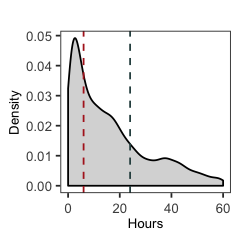

In [260]:
options(repr.plot.width=2, repr.plot.height=2)
p <- output_df %>%
    filter(!grepl(',', pressor)) %>%
    ggplot(aes(x=duration)) +
        base_theme() +
        #geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(aes(y = ..density..), alpha=0.6, fill="gray")+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="",x="Hours", y = "Density")+
        xlim(0, 60) +
        geom_vline(xintercept = 6, linetype= "dashed", color="firebrick") +
        geom_vline(xintercept = 24, linetype= "dashed", color="#2F4F4F")
plot(p)

In [261]:
pdf(file.path(PLOT_DIR, "histo_durations.pdf"), 2, 2)
plot(p)
dev.off()

Warning message:
“Removed 922 rows containing non-finite values (stat_density).”

pdf 
  2

#### Courses involving any of these pressors

Warning message:
“Removed 922 rows containing non-finite values (stat_density).”

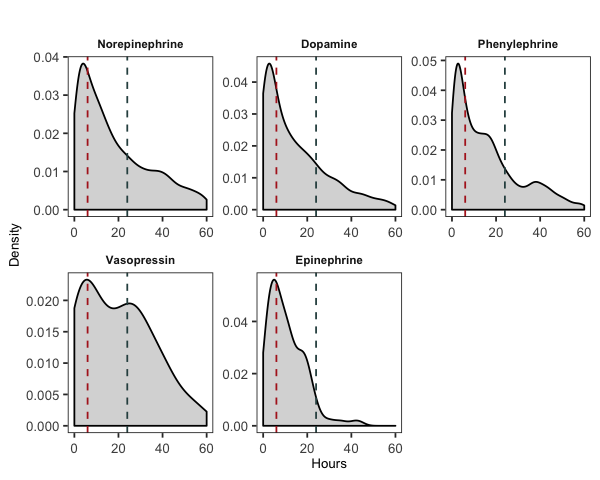

In [262]:
options(repr.plot.width=5, repr.plot.height=4)
p <- output_df %>%
    filter(!grepl(',', pressor)) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=duration)) +
        base_theme() +
        #geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(aes(y = ..density..), alpha=0.6, fill="gray")+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="",x="Hours", y = "Density")+
        xlim(0, 60) +
        geom_vline(xintercept = 6, linetype= "dashed", color="firebrick") +
        geom_vline(xintercept = 24, linetype= "dashed", color="#2F4F4F") +
        facet_wrap(. ~fancy_pressor, nrow=2, ncol=3, scale = "free")
plot(p)

In [263]:
pdf(file.path(PLOT_DIR, "histo_individual_durations.pdf"), 5, 4)
plot(p)
dev.off()

Warning message:
“Removed 922 rows containing non-finite values (stat_density).”

pdf 
  2

### Figure X. CVC associated with longer pressor courses

In [46]:
CVC_COLORS <- c(
"CVC" = '#2F4F4F',
"No CVC" = '#D3D3D3'
)

In [47]:
# <6 hour course
output_df %>%
    filter(!grepl(",", pressor)) %>%
    group_by(RESPONSE = STATUS == "LESSTHAN6HOURS", cvc) %>%
    summarize(COUNT = n(), DURATION = mean(duration)) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,DURATION,FREQ
<lgl>,<lgl>,<int>,<drtn>,<dbl>
FALSE,FALSE,1416,25.553684 hours,0.2061435
FALSE,TRUE,5453,38.046164 hours,0.7938565
TRUE,FALSE,917,2.973646 hours,0.2762880
TRUE,TRUE,2402,3.415015 hours,0.7237120


In [48]:
output_df %>%
    group_by(RESPONSE = STATUS == "MORETHAN24HOURS", cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,2152,0.2519021
FALSE,TRUE,6391,0.7480979
TRUE,FALSE,749,0.1157472
TRUE,TRUE,5722,0.8842528


In [49]:
output_df %>%
    group_by(RESPONSE = grepl(",", pressor), cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,2333,0.2289949
FALSE,TRUE,7855,0.7710051
TRUE,FALSE,568,0.1176958
TRUE,TRUE,4258,0.8823042


In [50]:
pairwise.wilcox.test(as.numeric(output_df$duration), output_df$cvc)


	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(output_df$duration) and output_df$cvc 

     FALSE 
TRUE <2e-16

P value adjustment method: holm 

Warning message:
“Removed 1998 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 1998 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1998 rows containing non-finite values (stat_summary).”

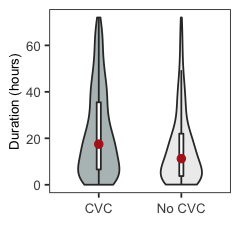

In [51]:
options(repr.plot.width=2, repr.plot.height=2)
p <- output_df %>%
    rowwise() %>%
    mutate(cvc_fancy = if(cvc){"CVC"}else{"No CVC"}) %>%
    mutate(cvc_fancy = factor(cvc_fancy, levels = names(CVC_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=cvc_fancy, y=duration)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Duration (hours)") +
        geom_violin(aes(fill=cvc_fancy), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,72)) +
        geom_boxplot(width=0.05, outlier.shape = NA)+
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick")
        #+ facet_grid(. ~fancy_pressor)
plot(p)

In [52]:
pdf(file.path(PLOT_DIR, "cvcduration.pdf"), 2,2)
plot(p)
dev.off()

Warning message:
“Removed 1998 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 1998 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1998 rows containing non-finite values (stat_summary).”

pdf 
  2

In [53]:
for(presor_choice in pressor_choices){
    pairwise.wilcox.test(as.numeric(filter(output_df,pressor==pressor_choice)$duration), 
                     filter(output_df,pressor==pressor_choice)$cvc) %>% 
    print()
}

ERROR: Error: object 'pressor_choice' not found


Warning message:
“Removed 663 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 663 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 663 rows containing non-finite values (stat_summary).”

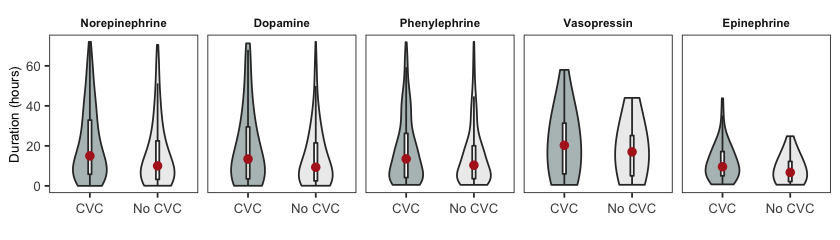

In [51]:
options(repr.plot.width=7, repr.plot.height=2)
p <- output_df %>%
    filter(!grepl(",", pressor)) %>%
    rowwise() %>%
    mutate(cvc_fancy = if(cvc){"CVC"}else{"No CVC"}) %>%
    mutate(cvc_fancy = factor(cvc_fancy, levels = names(CVC_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=cvc_fancy, y=duration)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Duration (hours)") +
        geom_violin(aes(fill=cvc_fancy), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,72)) +
        geom_boxplot(width=0.05, outlier.shape = NA) +
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick") +
        facet_grid(. ~fancy_pressor)
plot(p)

In [52]:
pdf(file.path(PLOT_DIR, "cvcduration_eachpressor.pdf"), 4,2)
plot(p)
dev.off()

Warning message:
“Removed 663 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 663 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 663 rows containing non-finite values (stat_summary).”

pdf 
  2

### Table 1 Demographics

In [32]:
# total_df <- output_df %>% 
#     summarize(
#             TOTAL = "TOTAL",
#             n = paste(round(as.numeric(n()),2), paste0('(', 100*(n()/nrow(output_df)) %>% round(3), '%)')), 
#             Age = paste(round(as.numeric(mean(age, na.rm=TRUE)),2), paste0('(SD=', sd(age, na.rm=TRUE) %>% round(2),')')), 
#             Male = paste(sum(gender == 'M'), paste0('(',100*round(sum(gender == 'M')/n(),3),'%)')),
#             MICU = paste(sum(first_careunit == 'MICU'), paste0('(',100*round(sum(first_careunit == 'MICU')/n(),3),'%)')),
#             SICU = paste(sum(first_careunit == 'SICU'), paste0('(',100*round(sum(first_careunit == 'SICU')/n(),3),'%)')),
#             CCU = paste(sum(first_careunit == 'CCU'), paste0('(',100*round(sum(first_careunit == 'CCU')/n(),3),'%)')),
#             TSICU = paste(sum(first_careunit == 'TSICU'), paste0('(',100*round(sum(first_careunit == 'TSICU')/n(),3),'%)')),
#             CSRU = paste(sum(first_careunit == 'CSRU'), paste0('(',100*round(sum(first_careunit == 'CSRU')/n(),3),'%)')),
#             Infectious = paste(sum(simple_diagnosis == "INFECTION"), paste0('(',100*round(sum(simple_diagnosis == "INFECTION")/n(),3),'%)')),
#             Cardiac = paste(sum(simple_diagnosis == "CARDIAC"), paste0('(',100*round(sum(simple_diagnosis == "CARDIAC")/n(),3),'%)')),
#             CVC = paste(sum(cvc == "TRUE"), paste0('(',100*round(sum(cvc == "TRUE")/n(),3),'%)')),
#             Intubated = paste(sum(intub == "TRUE"), paste0('(',100*round(sum(intub == "TRUE")/n(),3),'%)'))
#              ) %>% t() 

In [53]:
total_df <- output_df %>% 
    summarize(
            TOTAL = "TOTAL",
            n = paste(round(as.numeric(n()),2)), 
            Age = paste(round(as.numeric(mean(age, na.rm=TRUE)),2), paste0('(SD=', sd(age, na.rm=TRUE) %>% round(2),')')), 
            Male = paste(sum(gender == 'M')),
            MICU = paste(sum(first_careunit == 'MICU')),
            SICU = paste(sum(first_careunit == 'SICU')),
            CCU = paste(sum(first_careunit == 'CCU')),
            TSICU = paste(sum(first_careunit == 'TSICU')),
            CSRU = paste(sum(first_careunit == 'CSRU')),
            Infectious_Diagnosis = paste(sum(simple_diagnosis == "INFECTION")),
            Cardiac_Diagnosis = paste(sum(simple_diagnosis == "CARDIAC")),
            Other_Diagnosis = paste(sum(simple_diagnosis == "OTHER DIAGNOSIS")),
            Intubated = paste(sum(intub == "TRUE"))
             ) %>% t()

In [54]:
colnames(total_df) <- "TOTAL"

In [55]:
total_df

,TOTAL
TOTAL,TOTAL
n,15014
Age,65.81 (SD=13.96)
Male,8974
MICU,4106
SICU,1797
CCU,2023
TSICU,1285
CSRU,5803
Infectious_Diagnosis,1845


In [56]:
sum_df <- output_df %>% 
    rowwise() %>%
    mutate(STATUS = if(grepl(",", pressor)){"MULTI"}else{STATUS}) %>%
    group_by(STATUS) %>%
    summarize(
            n = n(), 
            Age = paste(round(as.numeric(mean(age, na.rm=TRUE)),2), paste0('(SD=', sd(age, na.rm=TRUE) %>% round(2),')')),
            Male = sum(gender == 'M'),
            MICU = sum(first_careunit == 'MICU'),
            SICU = sum(first_careunit == 'SICU'),
            CCU = sum(first_careunit == 'CCU'),
            TSICU = sum(first_careunit == 'TSICU'),
            CSRU = sum(first_careunit == 'CSRU'),
            Infectious_Diagnosis = sum(simple_diagnosis == "INFECTION"),
            Cardiac_Diagnosis = sum(simple_diagnosis == "CARDIAC"),
            Other_Diagnosis = sum(simple_diagnosis == "OTHER DIAGNOSIS"),
            Intubated = sum(intub == "TRUE")) 

Warning message in mutate_impl(.data, dots, caller_env()):
“binding factor and character vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercin

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

In [57]:
t1_df <- sum_df %>%
    ungroup() %>%
    mutate(
        n = paste(round(n,2), paste0('(', 100*(n/sum(n)) %>% round(3), '%)')),
        Male = paste(round(Male,2), paste0('(', 100*(Male/sum(Male)) %>% round(3), '%)')),
        MICU = paste(round(MICU,2), paste0('(', 100*(MICU/sum(MICU)) %>% round(3), '%)')),
        SICU = paste(round(SICU,2), paste0('(', 100*(SICU/sum(SICU)) %>% round(3), '%)')),
        CCU = paste(round(CCU,2), paste0('(', 100*(CCU/sum(CCU)) %>% round(3), '%)')),
        TSICU = paste(round(TSICU,2), paste0('(', 100*(TSICU/sum(TSICU)) %>% round(3), '%)')),
        CSRU = paste(round(CSRU,2), paste0('(', 100*(CSRU/sum(CSRU)) %>% round(3), '%)')),
        Infectious_Diagnosis = paste(round(Infectious_Diagnosis,2), paste0('(', 100*(Infectious_Diagnosis/sum(Infectious_Diagnosis)) %>% round(3), '%)')),
        Cardiac_Diagnosis = paste(round(Cardiac_Diagnosis,2), paste0('(', 100*(Cardiac_Diagnosis/sum(Cardiac_Diagnosis)) %>% round(3), '%)')),
        Other_Diagnosis = paste(round(Other_Diagnosis,2), paste0('(', 100*(Other_Diagnosis/sum(Other_Diagnosis)) %>% round(3), '%)')),
        Intubated = paste(round(Intubated,2), paste0('(', 100*(Intubated/sum(Intubated)) %>% round(3), '%)'))
    ) %>% t()

In [49]:
# t1_df <- output_df %>% 
#     rowwise() %>%
#     mutate(STATUS = if(grepl(",", pressor)){"MULTI"}else{STATUS}) %>%
#     group_by(STATUS) %>%
#     summarize(
#             n = paste(round(as.numeric(n()),2), paste0('(', 100*(n()/nrow(output_df)) %>% round(3), '%)')), 
#             Age = paste(round(as.numeric(mean(age, na.rm=TRUE)),2), paste0('(SD=', sd(age, na.rm=TRUE) %>% round(2),')')), 
#             Male = paste(sum(gender == 'M'), paste0('(',100*round(sum(gender == 'M')/n(),3),'%)')),
#             MICU = paste(sum(first_careunit == 'MICU'), paste0('(',100*round(sum(first_careunit == 'MICU')/n(),3),'%)')),
#             SICU = paste(sum(first_careunit == 'SICU'), paste0('(',100*round(sum(first_careunit == 'SICU')/n(),3),'%)')),
#             CCU = paste(sum(first_careunit == 'CCU'), paste0('(',100*round(sum(first_careunit == 'CCU')/n(),3),'%)')),
#             TSICU = paste(sum(first_careunit == 'TSICU'), paste0('(',100*round(sum(first_careunit == 'TSICU')/n(),3),'%)')),
#             CSRU = paste(sum(first_careunit == 'CSRU'), paste0('(',100*round(sum(first_careunit == 'CSRU')/n(),3),'%)')),
#             Infectious = paste(sum(simple_diagnosis == "INFECTION"), paste0('(',100*round(sum(simple_diagnosis == "INFECTION")/n(),3),'%)')),
#             Cardiac = paste(sum(simple_diagnosis == "CARDIAC"), paste0('(',100*round(sum(simple_diagnosis == "CARDIAC")/n(),3),'%)')),
#             CVC = paste(sum(cvc == "TRUE"), paste0('(',100*round(sum(cvc == "TRUE")/n(),3),'%)')),
#             Intubated = paste(sum(intub == "TRUE"), paste0('(',100*round(sum(intub == "TRUE")/n(),3),'%)'))
#              ) %>% t()

In [58]:
colnames(t1_df) <- t1_df[1,]

In [59]:
t1_df

,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS,MULTI
STATUS,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS,MULTI
n,3974 (26.5%),3319 (22.1%),2895 (19.3%),4826 (32.1%)
Age,65.27 (SD=13.83),66.19 (SD=13.85),65.4 (SD=13.87),66.24 (SD=14.17)
Male,2473 (27.6%),1966 (21.9%),1671 (18.6%),2864 (31.9%)
MICU,943 (23%),730 (17.8%),862 (21%),1571 (38.3%)
SICU,473 (26.3%),363 (20.2%),417 (23.2%),544 (30.3%)
CCU,490 (24.2%),419 (20.7%),383 (18.9%),731 (36.1%)
TSICU,342 (26.6%),270 (21%),292 (22.7%),381 (29.6%)
CSRU,1726 (29.7%),1537 (26.5%),941 (16.2%),1599 (27.6%)
Infectious_Diagnosis,461 (25%),302 (16.4%),396 (21.5%),686 (37.2%)


In [61]:
cbind(total_df,t1_df) %>% write.csv(file.path(PLOT_DIR, "response_demographics.csv"))

### Supplement Table (solo agents)

In [7]:
s1_3_df <- output_df %>% 
    filter(!grepl(",", pressor)) %>%
    group_by(STATUS, pressor) %>%
    summarize(
            n = n(), 
            Age = paste(round(as.numeric(mean(age, na.rm=TRUE)),2), paste0('(SD=', sd(age, na.rm=TRUE) %>% round(2),')')),
            Male = sum(gender == 'M'),
            MICU = sum(first_careunit == 'MICU'),
            SICU = sum(first_careunit == 'SICU'),
            CCU = sum(first_careunit == 'CCU'),
            TSICU = sum(first_careunit == 'TSICU'),
            CSRU = sum(first_careunit == 'CSRU'),
            Infectious_Diagnosis = sum(simple_diagnosis == "INFECTION"),
            Cardiac_Diagnosis = sum(simple_diagnosis == "CARDIAC"),
            Other_Diagnosis = sum(simple_diagnosis == "OTHER DIAGNOSIS"),
            Intubated = sum(intub == "TRUE")) %>%
    ungroup() %>%
    group_by(pressor) %>%
    mutate(
        n = paste(round(n,2), paste0('(', 100*(n/sum(n)) %>% round(3), '%)')),
        Male = paste(round(Male,2), paste0('(', 100*(Male/sum(Male)) %>% round(3), '%)')),
        MICU = paste(round(MICU,2), paste0('(', 100*(MICU/sum(MICU)) %>% round(3), '%)')),
        SICU = paste(round(SICU,2), paste0('(', 100*(SICU/sum(SICU)) %>% round(3), '%)')),
        CCU = paste(round(CCU,2), paste0('(', 100*(CCU/sum(CCU)) %>% round(3), '%)')),
        TSICU = paste(round(TSICU,2), paste0('(', 100*(TSICU/sum(TSICU)) %>% round(3), '%)')),
        CSRU = paste(round(CSRU,2), paste0('(', 100*(CSRU/sum(CSRU)) %>% round(3), '%)')),
        Infectious_Diagnosis = paste(round(Infectious_Diagnosis,2), paste0('(', 100*(Infectious_Diagnosis/sum(Infectious_Diagnosis)) %>% round(3), '%)')),
        Cardiac_Diagnosis = paste(round(Cardiac_Diagnosis,2), paste0('(', 100*(Cardiac_Diagnosis/sum(Cardiac_Diagnosis)) %>% round(3), '%)')),
        Other_Diagnosis = paste(round(Other_Diagnosis,2), paste0('(', 100*(Other_Diagnosis/sum(Other_Diagnosis)) %>% round(3), '%)')),
        Intubated = paste(round(Intubated,2), paste0('(', 100*(Intubated/sum(Intubated)) %>% round(3), '%)'))
    ) 

In [8]:
# s1_3_df <- output_df %>% 
#     filter(!grepl(",", pressor)) %>%
#     group_by(STATUS, pressor) %>%
#         summarize(n = paste(round(as.numeric(n()),2), paste0('(', 100*(n()/nrow(output_df)) %>% round(3), '%)')), 
#             Age = paste(round(as.numeric(mean(age, na.rm=TRUE)),2), paste0('(SD=', sd(age, na.rm=TRUE) %>% round(2),')')), 
#             Male = paste(sum(gender == 'M'), paste0('(',100*round(sum(gender == 'M')/n(),3),'%)')),
#             MICU = paste(sum(first_careunit == 'MICU'), paste0('(',100*round(sum(first_careunit == 'MICU')/n(),3),'%)')),
#             SICU = paste(sum(first_careunit == 'SICU'), paste0('(',100*round(sum(first_careunit == 'SICU')/n(),3),'%)')),
#             CCU = paste(sum(first_careunit == 'CCU'), paste0('(',100*round(sum(first_careunit == 'CCU')/n(),3),'%)')),
#             TSICU = paste(sum(first_careunit == 'TSICU'), paste0('(',100*round(sum(first_careunit == 'TSICU')/n(),3),'%)')),
#             CSRU = paste(sum(first_careunit == 'CSRU'), paste0('(',100*round(sum(first_careunit == 'CSRU')/n(),3),'%)')),
#             Sepsis = paste(sum(simple_diagnosis == "SEPSIS"), paste0('(',100*round(sum(simple_diagnosis == "SEPSIS")/n(),3),'%)')),
#             Infectious = paste(sum(simple_diagnosis == "INFECTION"), paste0('(',100*round(sum(simple_diagnosis == "INFECTION")/n(),3),'%)')),
#             Cardiac = paste(sum(simple_diagnosis == "CARDIAC"), paste0('(',100*round(sum(simple_diagnosis == "CARDIAC")/n(),3),'%)')),
#             CVC = paste(sum(cvc == "TRUE"), paste0('(',100*round(sum(cvc == "TRUE")/n(),3),'%)')),
#             Intubated = paste(sum(intub == "TRUE"), paste0('(',100*round(sum(intub == "TRUE")/n(),3),'%)'))
#              )

In [9]:
# s1_3_df <- output_df %>% 
#     filter(!grepl(",", pressor)) %>%
#     group_by(STATUS, pressor) %>%
#         summarize(n = n(), 
#             Age = paste(round(as.numeric(mean(age, na.rm=TRUE)),2), paste0('(SD=', sd(age, na.rm=TRUE) %>% round(2),')')), 
#             Male = paste(sum(gender == 'M'), paste0('(',100*round(sum(gender == 'M')/n(),3),'%)')),
#             MICU = paste(sum(first_careunit == 'MICU'), paste0('(',100*round(sum(first_careunit == 'MICU')/n(),3),'%)')),
#             SICU = paste(sum(first_careunit == 'SICU'), paste0('(',100*round(sum(first_careunit == 'SICU')/n(),3),'%)')),
#             CCU = paste(sum(first_careunit == 'CCU'), paste0('(',100*round(sum(first_careunit == 'CCU')/n(),3),'%)')),
#             TSICU = paste(sum(first_careunit == 'TSICU'), paste0('(',100*round(sum(first_careunit == 'TSICU')/n(),3),'%)')),
#             CSRU = paste(sum(first_careunit == 'CSRU'), paste0('(',100*round(sum(first_careunit == 'CSRU')/n(),3),'%)')),
#             Sepsis = paste(sum(simple_diagnosis == "SEPSIS"), paste0('(',100*round(sum(simple_diagnosis == "SEPSIS")/n(),3),'%)')),
#             Infectious = paste(sum(simple_diagnosis == "INFECTION"), paste0('(',100*round(sum(simple_diagnosis == "INFECTION")/n(),3),'%)')),
#             Cardiac = paste(sum(simple_diagnosis == "CARDIAC"), paste0('(',100*round(sum(simple_diagnosis == "CARDIAC")/n(),3),'%)')),
#             CVC = paste(sum(cvc == "TRUE"), paste0('(',100*round(sum(cvc == "TRUE")/n(),3),'%)')),
#             Intubated = paste(sum(intub == "TRUE"), paste0('(',100*round(sum(intub == "TRUE")/n(),3),'%)'))
#              )

In [15]:
for(pressor_choice in pressor_choices){
    out_df <- s1_3_df %>%
        filter(pressor == pressor_choice) %>%
        ungroup() %>%
        t()
    colnames(out_df) <- out_df[1,]
    out_df %>% 
        data.frame() %>%
        select(LESSTHAN6HOURS, LESSTHAN24HOURS, MORETHAN24HOURS) %>%
        write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_demographics.csv")))
}

# Categorical Predictors

In [49]:
# This function, given a dataframe with the appropriate columns, will compute RR statistics and return as a table 
calculatePredictors <- function(df){
    all_rr_list <- list()

    # gender
    output <- df %>%
        group_by(RESPONSE, gender) %>%
        summarize(COUNT = n()) %>%
        spread(RESPONSE, COUNT) %>%
        tibble::column_to_rownames("gender") %>%
        as.matrix() %>% riskratio()

    all_rr_list[['MALE_RR']] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'M') %>%
            mutate(ID = "M", p = output$p.value["M","fisher.exact"])


#     # race
#     rr_list <- list()
#     for(race in races){
#        output <- df %>%
#             rowwise() %>%
#             group_by(RESPONSE, simple_race) %>%
#             summarize(COUNT = n()) %>%
#             mutate(RACE_BOOL = simple_race == race) %>%
#             group_by(RACE_BOOL, RESPONSE) %>%
#             summarize(COUNT = sum(COUNT)) %>%
#             spread(RESPONSE, COUNT) %>%
#             tibble::column_to_rownames("RACE_BOOL") %>%
#             as.matrix() %>% riskratio() 
#         rr_list[[race]] <- output$measure %>%
#             data.frame() %>%
#             tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
#             mutate(ID = race, p = output$p.value["TRUE","fisher.exact"])
#     }


#     all_rr_list[['RACE_RR']] <- bind_rows(rr_list)


    # age
    age_df <- df %>%
        group_by(RESPONSE, age_cohort) %>%
        summarize(COUNT = n()) %>%
        drop_na(age_cohort)

    rr_list <- list()
    for(ac in unique(age_df$age_cohort)){
       if(ac != 0){
           output <- age_df %>%
                mutate(AGE_BOOL = age_cohort == ac) %>%
                group_by(AGE_BOOL, RESPONSE) %>%
                summarize(COUNT = sum(COUNT)) %>%
                spread(RESPONSE, COUNT) %>%
                tibble::column_to_rownames("AGE_BOOL") %>%
                as.matrix() %>% riskratio() 

            rr_list[[ac]] <- output$measure %>%
                data.frame() %>%
                tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
                mutate(ID = as.character(ac), p = output$p.value["TRUE","fisher.exact"])
       }  
    }

    all_rr_list[['AGE_RR']] <- bind_rows(rr_list)


    # diagnosis
    diagnosis_df <- df %>%
        rowwise() %>%
        group_by(simple_diagnosis, RESPONSE) %>%
        summarize(COUNT = n()) 

    rr_list <- list()
    for(s_d in unique(diagnosis_df$simple_diagnosis)){
       output <- diagnosis_df %>%
            mutate(DX_BOOL = simple_diagnosis == s_d) %>%
            group_by(DX_BOOL, RESPONSE) %>%
            summarize(COUNT = sum(COUNT)) %>%
            spread(RESPONSE, COUNT) %>%
            tibble::column_to_rownames("DX_BOOL") %>%
            as.matrix() %>% riskratio() 
        rr_list[[s_d]] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = s_d, p = output$p.value["TRUE","fisher.exact"])
    }

    all_rr_list[['DIAGNOSIS_RR']] <- bind_rows(rr_list)


#     # careunit
#     careunit_df <- df %>%
#         group_by(RESPONSE, first_careunit) %>%
#         summarize(COUNT = n())

#     rr_list <- list()
#     for(cu in unique(careunit_df$first_careunit)){
#        output <- careunit_df%>%
#             mutate(CU_BOOL = first_careunit == cu) %>%
#             group_by(CU_BOOL, RESPONSE) %>%
#             summarize(COUNT = sum(COUNT)) %>%
#             spread(RESPONSE, COUNT) %>%
#             tibble::column_to_rownames("CU_BOOL") %>%
#             as.matrix() %>% riskratio() 
#         rr_list[[cu]] <- output$measure %>%
#             data.frame() %>%
#             tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
#             mutate(ID = cu, p = output$p.value["TRUE","fisher.exact"])
#     }

#     all_rr_list[['CAREUNIT_RR']] <- bind_rows(rr_list)


    # intub
    output <- df %>%
        group_by(RESPONSE, intub) %>%
        summarize(COUNT = n()) %>%
        spread(RESPONSE, COUNT) %>%
        tibble::column_to_rownames("intub") %>%
        as.matrix() %>% riskratio()

    all_rr_list[['INTUB_RR']] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = "INTUB", p = output$p.value["TRUE","fisher.exact"])

#     # cvc
#     output <- df %>%
#         group_by(RESPONSE, cvc) %>%
#         summarize(COUNT = n()) %>%
#         spread(RESPONSE, COUNT) %>%
#         tibble::column_to_rownames("cvc") %>%
#         as.matrix() %>% riskratio()

#     all_rr_list[['CVC_RR']] <- output$measure %>%
#             data.frame() %>%
#             tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
#             mutate(ID = "CVC", p = output$p.value["TRUE","fisher.exact"])


    # combined
    all_rr_df <- bind_rows(all_rr_list, .id="TYPE") %>%
        mutate(significant = p < 0.05)
    
    return(all_rr_df)
}


# Table 1 (RR significance)

In [50]:
rr_df <- calculatePredictors(output_df) %>%
    rowwise() %>%
    mutate(ID = if(ID == "M"){"MALE"}else{ID}) %>% select(-FILTER)
rr_df

Warning message:
“Grouping rowwise data frame strips rowwise nature”

TYPE,estimate,lower,upper,ID,p,significant
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>
MALE_RR,0.9580372,0.9283813,0.9886405,MALE,8.110483e-03,TRUE
AGE_RR,0.9305726,0.7811814,1.1085330,20,4.414252e-01,FALSE
AGE_RR,1.0419116,0.9368666,1.1587346,30,4.858992e-01,FALSE
AGE_RR,1.0532571,0.9808469,1.1310128,40,1.695964e-01,FALSE
AGE_RR,0.9730783,0.9276450,1.0207368,50,2.585131e-01,FALSE
AGE_RR,0.9742035,0.9372005,1.0126674,60,1.866154e-01,FALSE
AGE_RR,0.9824596,0.9473928,1.0188244,70,3.446702e-01,FALSE
AGE_RR,1.0515762,1.0145458,1.0899582,80,6.907671e-03,TRUE
AGE_RR,0.9777858,0.9078998,1.0530513,90,5.676840e-01,FALSE


In [51]:
rr_df %>% 
    write.csv(file.path(PLOT_DIR, "relativerisk.csv"))

# Continuous Predictors

In [52]:
PRESSORHOURS_DICT <- c(
'TRUE' = "Prolonged or multiple vasopressor",
'FALSE' = "No prolonged or multiple vasopressor"
)

In [53]:
PRESSORHOURS_COLORS <- c(
"Prolonged or multiple vasopressor" = '#2F4F4F',
"No prolonged or multiple vasopressor" = '#D3D3D3'
)

In [54]:
SEPSIS_COLORS <- c(
"Sepsis" = '#2F4F4F',
"Not sepsis" = '#D3D3D3'
)

In [55]:
severity_output_df <- output_df %>%
    rowwise() %>%
    mutate(PRESSORHOURS = PRESSORHOURS_DICT[as.character(RESPONSE)]) %>%
    mutate(SEPSIS = if(simple_diagnosis == "SEPSIS"){"Sepsis"}else("Not sepsis"))

In [72]:
library(ggpubr)

Loading required package: magrittr

Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract



In [253]:
 severity_output_df %>%
    group_by(PRESSORHOURS) %>%
    summarize(sofa = mean(sofa))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

PRESSORHOURS,sofa
<chr>,<dbl>
No prolonged or multiple vasopressor,5.065954
Prolonged or multiple vasopressor,7.211372


In [254]:
 severity_output_df %>%
    group_by(PRESSORHOURS) %>%
    summarize(oasis = mean(oasis))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

PRESSORHOURS,oasis
<chr>,<dbl>
No prolonged or multiple vasopressor,33.34238
Prolonged or multiple vasopressor,37.10504


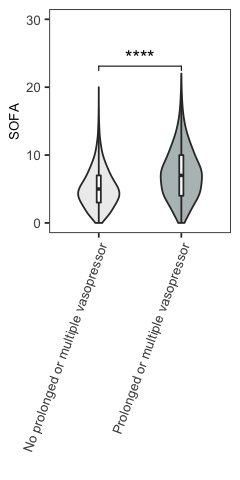

In [75]:
options(repr.plot.width=2, repr.plot.height=4)
p <- severity_output_df %>%
    ggplot(aes(x=PRESSORHOURS, y=sofa)) +
        base_theme() + 
        theme(legend.position="none", axis.text.x=element_text(vjust=1, hjust=1, angle=70)) +
        xlab("") +
        ylab("SOFA") +
        geom_violin(aes(fill=PRESSORHOURS), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=PRESSORHOURS_COLORS) +
        scale_y_continuous(limits=c(0,30)) +
        geom_boxplot(width=0.05, outlier.shape = NA) +
        stat_compare_means(method="wilcox.test", label = "p.signif", comparisons = list(c("Prolonged or multiple vasopressor", "No prolonged or multiple vasopressor")), size = 4)
        #stat_summary(fun.y=median, geom="point", size=2, color="firebrick")
plot(p)

In [76]:
pdf(file.path(PLOT_DIR, "sofa.pdf"), 2,4)
plot(p)
dev.off()

pdf 
  2

In [77]:
 severity_output_df %>%
    group_by(PRESSORHOURS) %>%
    summarize(oasis = mean(oasis))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

PRESSORHOURS,oasis
<chr>,<dbl>
No prolonged or multiple vasopressor,33.34238
Prolonged or multiple vasopressor,37.10504


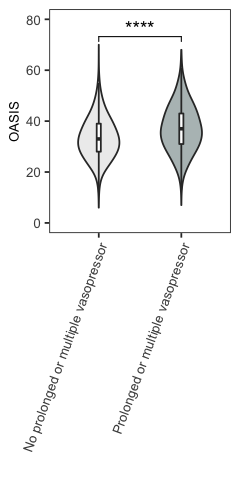

In [79]:
options(repr.plot.width=2, repr.plot.height=4)
p <- severity_output_df %>%
    ggplot(aes(x=PRESSORHOURS, y=oasis)) +
        base_theme() + 
        theme(legend.position="none", axis.text.x=element_text(vjust=1, hjust=1, angle=70)) +
        xlab("") +
        ylab("OASIS") +
        geom_violin(aes(fill=PRESSORHOURS), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=PRESSORHOURS_COLORS) +
        scale_y_continuous(limits=c(0,80)) +
        geom_boxplot(width=0.05, outlier.shape = NA) +
        stat_compare_means(method="wilcox.test", label = "p.signif", comparisons = list(c("Prolonged or multiple vasopressor", "No prolonged or multiple vasopressor")), size = 4)
        #stat_summary(fun.y=median, geom="point", size=2, color="firebrick")
plot(p)

In [80]:
pdf(file.path(PLOT_DIR, "oasis.pdf"), 2,4)
plot(p)
dev.off()

pdf 
  2

### Supplement (single agents)
- Insufficient numbers for RR analysis for epinephrine and vasopressin

In [56]:
pressor_rr_list <- list()
for(pressor_choice in c('norepinephrinedurations', 'dopaminedurations', 'phenylephrinedurations')){
    pressor_rr_list[[pressor_choice]] <- output_df %>%
        filter(grepl(pressor_choice, pressor)) %>%
        calculatePredictors()
}

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [57]:
pressor_rr_df <- bind_rows(pressor_rr_list, .id="pressor")  %>% select(-FILTER)

In [58]:
pressor_rr_df

pressor,TYPE,estimate,lower,upper,ID,p,significant
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>
norepinephrinedurations,MALE_RR,1.0174289,0.9863344,1.0495037,M,2.739417e-01,FALSE
norepinephrinedurations,AGE_RR,0.9206882,0.7752563,1.0934018,20,3.221528e-01,FALSE
norepinephrinedurations,AGE_RR,1.0225148,0.9307565,1.1233191,30,7.126702e-01,FALSE
norepinephrinedurations,AGE_RR,1.0184104,0.9514393,1.0900956,40,6.439978e-01,FALSE
norepinephrinedurations,AGE_RR,1.0115789,0.9674838,1.0576837,50,6.392121e-01,FALSE
norepinephrinedurations,AGE_RR,0.9826081,0.9451609,1.0215389,60,3.693405e-01,FALSE
norepinephrinedurations,AGE_RR,1.0176988,0.9819856,1.0547109,70,3.557296e-01,FALSE
norepinephrinedurations,AGE_RR,1.0017223,0.9666121,1.0381078,80,9.463445e-01,FALSE
norepinephrinedurations,AGE_RR,0.9517569,0.8857597,1.0226715,90,1.676055e-01,FALSE


In [59]:
pressor_rr_df %>% 
    write.csv(file.path(PLOT_DIR, "relativerisk_eachpressor.csv"))

# Plotting RR

In [60]:
ID_DICT <- c(
'M' = "Male Gender",
'INTUB' = "Intubated",
#'CVC' = "CVC Placed",
'20' = "Age 15-25",
'30' = "Age 25-35",
'40' = "Age 35-45",
'50' = "Age 45-55",
'60' = "Age 55-65",
'70' = "Age 65-75",
'80' = "Age 75-85",
'90' = "Age 85-95",
'CARDIAC' = "Cardiac Diagnosis",
'INFECTION' = "Infectious Diagnosis",
'OTHER DIAGNOSIS' = "Other Diagnosis" #,
# 'CCU' = 'CCU',
# 'CSRU' = 'CSRU',
# 'MICU' = 'MICU',
# 'SICU' = 'SICU',
# 'TSICU' = 'TSICU'
)

Warning message:
“Grouping rowwise data frame strips rowwise nature”

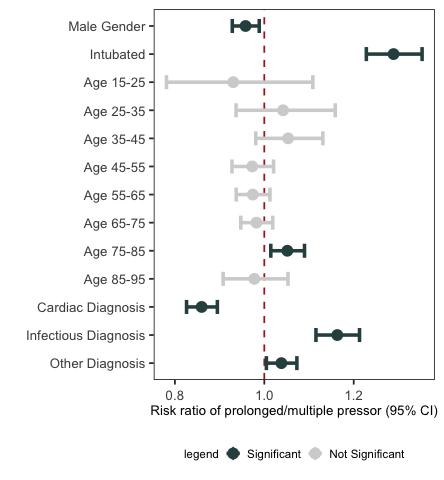

In [61]:
options(repr.plot.width=3.7, repr.plot.height=4)
p <- calculatePredictors(output_df)  %>%
    rowwise() %>%
    mutate(ID = ID_DICT[ID]) %>% 
    mutate(ID = factor(ID, levels=rev(ID_DICT))) %>%
    mutate(significant = if(significant){'Significant'}else{'Not Significant'}) %>%
    mutate(legend = factor(significant, levels=names(SIGNIFICANT_COLORS))) %>%
    ggplot(aes(x = ID,y = estimate, ymin = lower, ymax = upper ))+
        base_theme() +
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Risk ratio of prolonged/multiple pressor (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=significant),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [62]:
pdf(file.path(PLOT_DIR, "relativerisk.pdf"), 3.7,4)
plot(p)
dev.off()

pdf 
  2

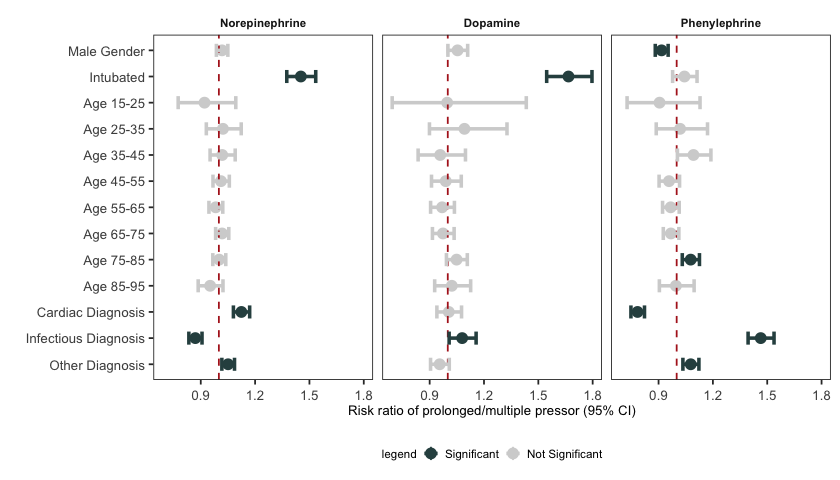

In [63]:
options(repr.plot.width=7, repr.plot.height=4)
p <- pressor_rr_df  %>%
    rowwise() %>%
    mutate(ID = ID_DICT[ID]) %>% 
    mutate(ID = factor(ID, levels=rev(ID_DICT))) %>%
    mutate(significant = if(significant){'Significant'}else{'Not Significant'}) %>%
    mutate(legend = factor(significant, levels=names(SIGNIFICANT_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x = ID,y = estimate, ymin = lower, ymax = upper ))+
        base_theme() +
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Risk ratio of prolonged/multiple pressor (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=significant),width=0.5,cex=1)+ 
        coord_flip() + 
        facet_grid(. ~fancy_pressor)
plot(p)

In [64]:
pdf(file.path(PLOT_DIR, "relativerisk_eachpressor.pdf"), 7,4)
plot(p)
dev.off()

pdf 
  2

# Vitals

### Pre-processing (30 minutes): read in vitals_df, join with output_df of courses and compute mean vitals information each hour -> results_df

In [134]:
vitals_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/vitals.csv')

In [135]:
# takes 6 mins to run (because of difftime)

vitals_merged_df <- vitals_df %>%
    mutate(charttime = fastPOSIXct(charttime)) %>%
    filter(icustay_id %in% output_df$icustay_id) %>%
    left_join(select(output_df, icustay_id, course_id, pressor, starttime, endtime, MORETHAN24HOURS, RESPONSE, STATUS), by = "icustay_id") %>%
    rowwise() %>%
    mutate(diff = difftime(charttime, 
                       starttime, units="hours"))

In [136]:
# for 10 hours prior to pressor initiation
intervals <- 1:10

In [137]:
results_list <- list()

In [138]:
# takes 40 mins to run overall
for(interval in intervals){
    # 4 mins to run each
    results_list[[interval]] <- vitals_merged_df %>%
        filter(diff < 0) %>%
        filter(diff < -(interval - 1) & diff > -interval) %>%
        group_by(MORETHAN24HOURS, RESPONSE, STATUS, course_id, pressor) %>%
        summarize(mean_heartrate = mean(heartrate, na.rm=T), 
                  mean_sysbp = mean(sysbp, na.rm=T),
                  mean_diasbp = mean(diasbp, na.rm=T),
                  mean_meanbp = mean(meanbp, na.rm=T), 
                  mean_resprate = mean(resprate, na.rm=T), 
                  mean_tempc = mean(tempc, na.rm=T), 
                  mean_spo2 = mean(spo2, na.rm=T), 
                  mean_glucose = mean(glucose, na.rm=T), 

                  median_heartrate = median(heartrate, na.rm=T), 
                  median_sysbp = median(sysbp, na.rm=T),
                  median_diasbp = median(diasbp, na.rm=T),
                  median_meanbp = median(meanbp, na.rm=T), 
                  median_resprate = median(resprate, na.rm=T), 
                  median_tempc = median(tempc, na.rm=T), 
                  median_spo2 = median(spo2, na.rm=T), 
                  median_glucose = median(glucose, na.rm=T),

                 ) %>%
        mutate(INTERVAL = interval)

}

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [139]:
results_df <- bind_rows(results_list) 

In [140]:
melt_results_df <- results_df %>% 
    gather("ID", "VALUE", -course_id, -pressor, -MORETHAN24HOURS, -INTERVAL, -STATUS, -RESPONSE)

In [96]:
melt_results_df %>% write.csv('~/Projects/Haimovich_Pressors/collection/out/melt_summarized_vitals.csv')

### Read-in directly

In [6]:
melt_results_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/melt_summarized_vitals.csv')

In [95]:
# melt_results_df <- melt_results_df %>%
#     filter(!grepl("dobutamine", pressor))


### ANCOVA analysis using intervals
- MORETHAN24HOURS P-value tells you if this vital sign is a predictor (BP, HR, RR, TEMP)
- INTERVAL P-value tells you if these values change depending on the interval being measured (most values)
- MORETHAN24HOURS:INTERVAL P-value tells you if vital sign interacts with the interval being measured, that is, the extent of predictive value differs with time (BP especially, others are borderline significant)

In [97]:
computeANCOVA <- function(df) {
    vitals_result_list <- list()
    for(vital in unique(df$ID)){
        #cat("####", vital, "####")
        totest <- df %>%
             filter(ID == vital)
        test <- summary(aov(VALUE ~ RESPONSE*INTERVAL, data = totest))[[1]]
        
        # The space is necessary
        vitals_result_list[[vital]] <- data.frame(RESPONSE = test["RESPONSE ", "Pr(>F)"],
                                                RESPONSE_F = test["RESPONSE ", "F value"],
                                                 INTERACTION = test["RESPONSE:INTERVAL", "Pr(>F)"],
                                                 INTERACTION_F = test["RESPONSE:INTERVAL", "F value"])
    }
    vitals_result_df <- bind_rows(vitals_result_list, .id="ID")
    
    return(vitals_result_df)
}

In [55]:
computeRandomEffects <- function(df){
    vitals_result_list <- list()
    for(vital in unique(df$ID)){
        #cat("####", vital, "####")
        totest <- df %>%
             filter(ID == vital)
        
        test <- lmer(VALUE ~ RESPONSE*INTERVAL + (1|course_id), data = totest) 
        ci <- confint(test, nsim=500)
        ce <- coef(summary(test))
        
        # The space is necessary
        vitals_result_list[[vital]] <- data.frame(INTERACTION = ce['RESPONSETRUE:INTERVAL',][1],
            INTERACTION_LOWER = ci['RESPONSETRUE:INTERVAL',][1],
            INTERACTION_UPPER = ci['RESPONSETRUE:INTERVAL',][2],
            RESPONSE =  ce["RESPONSETRUE",][1],
            RESPONSE_LOWER = ci["RESPONSETRUE",][1],
            RESPONSE_UPPER = ci["RESPONSETRUE",][2])
        
    }
    vitals_result_df <- bind_rows(vitals_result_list, .id="ID")
    
    return(vitals_result_df)
    
}

# Table 2 (Wilcox and ANCOVA Vitals)

In [98]:
computeTest <- function(d, value="VALUE", comparison="GROUP"){
    paired_df <- d %>% 
        select(!!rlang::sym(comparison), !!rlang::sym(value)) 
    
    items <- unique(unlist(d[,comparison]))

    result_unpair <- t.test(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, 
       filter(d, !!rlang::sym(comparison) == items[2])$VALUE, paired = FALSE)
    result_wilcox <- wilcox.test(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, 
       filter(d, !!rlang::sym(comparison) == items[2])$VALUE, paired = FALSE)
    
    diff = mean(filter(d, !!rlang::sym(comparison) == items[1])$VALUE) -  
        mean(filter(d, !!rlang::sym(comparison) == items[2])$VALUE)
    
    return(data.frame(list(
                           'P_UNPAIR' = result_unpair$p.value, 
                           'P_WILCOX' = result_wilcox$p.value,
                            'GROUP1' = mean(filter(d, !!rlang::sym(comparison) == items[1])$VALUE),
                            'GROUP2' = mean(filter(d, !!rlang::sym(comparison) == items[2])$VALUE),
                            'DIFF' = diff,
                            'COMPARE' = paste(items[1], items[2], sep ='-'))))
}

### Table 2. mean and standard deviation of vitals  for different time status

In [99]:
# means
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    group_by(ID, STATUS) %>%
    summarize(MEAN = mean(VALUE)) %>%
    spread(STATUS, MEAN)

ID,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
<fct>,<dbl>,<dbl>,<dbl>
mean_diasbp,55.33527,57.03602,54.81788
mean_glucose,145.61000,143.91518,150.36651
mean_heartrate,87.64036,85.59046,91.57193
mean_meanbp,71.67609,73.68740,70.44854
mean_resprate,17.29608,17.12634,18.46916
mean_spo2,97.61705,97.82267,97.20917
mean_sysbp,106.01837,109.61970,103.99360
mean_tempc,36.45199,36.37350,36.44814
median_diasbp,55.20944,56.81991,54.60934


In [100]:
# standard deviations
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    group_by(ID, STATUS) %>%
    summarize(SD = sd(VALUE)) %>%
    spread(STATUS, SD)

ID,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
<fct>,<dbl>,<dbl>,<dbl>
mean_diasbp,12.524111,13.780464,13.362265
mean_glucose,58.456002,57.551110,66.370311
mean_heartrate,18.730800,18.501391,20.677602
mean_meanbp,14.274077,15.202561,15.451841
mean_resprate,5.624617,5.489906,6.059303
mean_spo2,4.791078,4.365518,4.609067
mean_sysbp,18.866128,20.548302,20.111952
mean_tempc,1.108678,1.139698,1.159313
median_diasbp,12.698307,13.938376,13.513659


In [101]:
# means
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    filter(!grepl(",", pressor)) %>%
    drop_na(VALUE) %>%
    group_by(ID, STATUS, pressor) %>%
    summarize(MEAN = mean(VALUE)) %>%
    ungroup() %>%
    filter(pressor %in% pressor_choices) %>%
    spread(STATUS, MEAN) %>% arrange(pressor)

ID,pressor,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
<fct>,<fct>,<dbl>,<dbl>,<dbl>
mean_diasbp,dopaminedurations,52.61859,54.49779,53.00808
mean_glucose,dopaminedurations,180.39103,150.63211,174.20320
mean_heartrate,dopaminedurations,80.27786,82.37076,80.48769
mean_meanbp,dopaminedurations,69.80272,70.51865,69.25356
mean_resprate,dopaminedurations,18.43014,18.70692,18.62621
mean_spo2,dopaminedurations,96.24040,96.33417,96.35540
mean_sysbp,dopaminedurations,107.61782,107.05742,105.15319
mean_tempc,dopaminedurations,36.43495,36.34089,36.18671
median_diasbp,dopaminedurations,52.45520,54.19145,52.73840


In [102]:
# standard deviations
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    filter(!grepl(",", pressor)) %>%
    drop_na(VALUE) %>%
    group_by(ID, STATUS, pressor) %>%
    summarize(SD = sd(VALUE)) %>%
    ungroup() %>%
    filter(pressor %in% pressor_choices) %>%
    spread(STATUS, SD) %>% arrange(pressor)

ID,pressor,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
<fct>,<fct>,<dbl>,<dbl>,<dbl>
mean_diasbp,dopaminedurations,12.7906202,15.7193492,14.8872709
mean_glucose,dopaminedurations,87.3779909,61.5104168,93.1330078
mean_heartrate,dopaminedurations,20.0150240,21.1486787,20.0199026
mean_meanbp,dopaminedurations,14.0409250,16.7832830,14.7906514
mean_resprate,dopaminedurations,4.6882819,5.1137079,5.2042878
mean_spo2,dopaminedurations,5.1616965,5.6001365,5.2061020
mean_sysbp,dopaminedurations,21.5790203,22.2784202,21.4972558
mean_tempc,dopaminedurations,1.0107987,1.0255523,1.0138626
median_diasbp,dopaminedurations,12.8542871,15.7292885,14.9417167


### Wilcox for significant difference at <1 hr before start of pressors

All pressors

In [103]:
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    group_by(ID) %>%
    do(computeTest(.,value="VALUE", comparison="RESPONSE")) %>%
    mutate(significant = P_WILCOX < 0.05)

ID,P_UNPAIR,P_WILCOX,GROUP1,GROUP2,DIFF,COMPARE,significant
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
mean_diasbp,1.691412e-09,1.891648e-12,56.31073,54.75245,1.55827012,FALSE-TRUE,TRUE
mean_glucose,1.914612e-09,1.298892e-05,142.34116,152.01078,-9.66962305,FALSE-TRUE,TRUE
mean_heartrate,8.746582e-48,6.863921e-48,86.02469,91.55895,-5.53425774,FALSE-TRUE,TRUE
mean_meanbp,2.581244e-18,8.336113e-25,72.93059,70.36723,2.56336092,FALSE-TRUE,TRUE
mean_resprate,7.073272e-41,2.465690e-39,17.01244,18.47125,-1.45881412,FALSE-TRUE,TRUE
mean_spo2,3.649560e-23,2.115881e-26,97.94554,97.04405,0.90148793,FALSE-TRUE,TRUE
mean_sysbp,1.120009e-28,3.309293e-37,108.20581,103.88304,4.32277732,FALSE-TRUE,TRUE
mean_tempc,5.340081e-01,3.312432e-01,36.44070,36.42094,0.01976902,FALSE-TRUE,FALSE
median_diasbp,5.570312e-10,5.784365e-13,56.16076,54.53743,1.62333315,FALSE-TRUE,TRUE


Pressors by type

In [104]:
melt_results_df %>%
    filter(!grepl(",", pressor)) %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    mutate(pressor = factor(pressor, levels=pressor_choices)) %>%
    group_by(ID, pressor) %>%
    do(computeTest(.,value="VALUE", comparison="RESPONSE")) %>%
    mutate(significant = P_WILCOX < 0.05) %>%
    arrange(pressor)

Warning message in wilcox.test.default(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(filter(d,

ID,pressor,P_UNPAIR,P_WILCOX,GROUP1,GROUP2,DIFF,COMPARE,significant
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
mean_diasbp,norepinephrinedurations,8.627919e-03,1.045164e-03,55.77303,53.87910,1.89393032,FALSE-TRUE,TRUE
mean_glucose,norepinephrinedurations,5.318814e-02,5.178592e-02,163.16307,152.05244,11.11062868,FALSE-TRUE,FALSE
mean_heartrate,norepinephrinedurations,1.732808e-02,7.070951e-03,88.63319,90.81910,-2.18591184,FALSE-TRUE,TRUE
mean_meanbp,norepinephrinedurations,2.053741e-04,2.404272e-06,70.52472,67.60699,2.91772613,FALSE-TRUE,TRUE
mean_resprate,norepinephrinedurations,6.860357e-04,1.754619e-04,19.18622,20.10123,-0.91500249,FALSE-TRUE,TRUE
mean_spo2,norepinephrinedurations,6.458184e-02,1.294864e-02,97.14306,96.72060,0.42246337,FALSE-TRUE,TRUE
mean_sysbp,norepinephrinedurations,2.253928e-06,1.389227e-08,105.74318,100.95061,4.79257450,FALSE-TRUE,TRUE
mean_tempc,norepinephrinedurations,4.271811e-01,5.271884e-01,36.55380,36.62525,-0.07144869,FALSE-TRUE,FALSE
median_diasbp,norepinephrinedurations,8.831397e-03,1.358616e-03,55.59104,53.68101,1.91002808,FALSE-TRUE,TRUE


### Compute RandomEffects model

In [60]:
randomeffects_significance_df  <- computeRandomEffects(melt_results_df)

Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...


In [66]:
randomeffects_significance_df 

ID,INTERACTION,INTERACTION_LOWER,INTERACTION_UPPER,RESPONSE,RESPONSE_LOWER,RESPONSE_UPPER
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mean_heartrate,-0.0815978897,-0.158263409,-0.004945061,5.11841951,4.3956721,5.841147553
mean_sysbp,-0.0577462940,-0.178010440,0.062504609,-4.29689610,-5.0668169,-3.526978030
mean_diasbp,0.0205267840,-0.055986819,0.097051207,-1.47647059,-1.9859233,-0.967019617
mean_meanbp,0.0009040676,-0.090255554,0.092073319,-2.55208880,-3.1316675,-1.972509704
mean_resprate,0.0619393422,0.031628298,0.092246258,1.47335180,1.2539467,1.692746021
mean_tempc,0.0235361029,0.015636884,0.031431912,-0.05877013,-0.1123167,-0.005227152
mean_spo2,0.0275409440,0.003270588,0.051815078,-1.00115363,-1.1573872,-0.844917921
mean_glucose,-0.9536216382,-1.374422398,-0.532784412,9.61324297,7.0951837,12.131319716
median_heartrate,-0.0817718085,-0.159279805,-0.004276849,5.13746067,4.4117753,5.863125998


### ANCOVA for significant differences summarized

Total pressors

In [121]:
ancova_significance_df <- computeANCOVA(melt_results_df) %>% mutate(
    response_significant = RESPONSE < 0.05, 
    interaction_interaction = INTERACTION < 0.05) %>%
    rename(response_pvalue = RESPONSE, interaction_pvalue = INTERACTION, vital_sign = ID)
ancova_significance_df

vital_sign,response_pvalue,RESPONSE_F,interaction_pvalue,INTERACTION_F,response_significant,interaction_interaction
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
mean_heartrate,8.328245e-104,470.8331266,6.574443e-05,15.93289615,TRUE,TRUE
mean_sysbp,2.103223e-100,455.0448789,4.101657e-02,4.17560139,TRUE,TRUE
mean_diasbp,2.729850e-13,53.4300891,1.402025e-01,2.17582196,TRUE,FALSE
mean_meanbp,3.805099e-45,199.3038759,4.644524e-01,0.53515376,TRUE,FALSE
mean_resprate,2.906395e-171,785.4977140,8.263633e-01,0.04812297,TRUE,FALSE
mean_tempc,7.419364e-01,0.1084354,3.289467e-01,0.95309239,FALSE,FALSE
mean_spo2,2.032241e-87,394.7564332,2.198825e-04,13.65558215,TRUE,TRUE
mean_glucose,4.589886e-24,102.5567560,4.873348e-02,3.88483189,TRUE,TRUE
median_heartrate,5.205803e-104,471.7818874,6.452828e-05,15.96825394,TRUE,TRUE


In [122]:
ancova_significance_df

vital_sign,response_pvalue,RESPONSE_F,interaction_pvalue,INTERACTION_F,response_significant,interaction_interaction
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
mean_heartrate,8.328245e-104,470.8331266,6.574443e-05,15.93289615,TRUE,TRUE
mean_sysbp,2.103223e-100,455.0448789,4.101657e-02,4.17560139,TRUE,TRUE
mean_diasbp,2.729850e-13,53.4300891,1.402025e-01,2.17582196,TRUE,FALSE
mean_meanbp,3.805099e-45,199.3038759,4.644524e-01,0.53515376,TRUE,FALSE
mean_resprate,2.906395e-171,785.4977140,8.263633e-01,0.04812297,TRUE,FALSE
mean_tempc,7.419364e-01,0.1084354,3.289467e-01,0.95309239,FALSE,FALSE
mean_spo2,2.032241e-87,394.7564332,2.198825e-04,13.65558215,TRUE,TRUE
mean_glucose,4.589886e-24,102.5567560,4.873348e-02,3.88483189,TRUE,TRUE
median_heartrate,5.205803e-104,471.7818874,6.452828e-05,15.96825394,TRUE,TRUE


In [123]:
ancova_significance_df %>% write.csv(file.path(PLOT_DIR, "ancovasignificance.csv"))

Pressors by type

In [77]:
pressors_vitals_rr_list <- list()
for(pressor_choice in pressor_choices){
    pressors_vitals_rr_list[[pressor_choice]] <- melt_results_df %>%
        filter(grepl(pressor_choice, pressor)) %>%
        computeRandomEffects()
}

pressors_vitals_randomeffects_df <- bind_rows(pressors_vitals_rr_list, .id="pressor")

Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing p

In [82]:
pressors_vitals_randomeffects_df %>% arrange(ID) %>% filter(grepl("mean", ID))

pressor,ID,INTERACTION,INTERACTION_LOWER,INTERACTION_UPPER,RESPONSE,RESPONSE_LOWER,RESPONSE_UPPER
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
norepinephrinedurations,mean_diasbp,0.023316567,-0.114492906,0.161234439,-1.415030868,-2.35944277,-0.470686640
dopaminedurations,mean_diasbp,-0.006410193,-0.226634051,0.213846499,-1.018297348,-2.44451322,0.407986418
phenylephrinedurations,mean_diasbp,0.062810963,-0.029937330,0.155570830,-1.392587378,-1.99776835,-0.787411076
vasopressindurations,mean_diasbp,-0.159184197,-0.797759359,0.479195047,-0.688085014,-6.12247648,4.745854456
epinephrinedurations,mean_diasbp,0.015036556,-0.118091101,0.148263582,-1.327412815,-2.21113452,-0.443744953
norepinephrinedurations,mean_glucose,-1.480565313,-2.437030412,-0.523465843,7.196910053,1.05279104,13.341844679
dopaminedurations,mean_glucose,-0.817694377,-3.013963566,1.376475473,16.168745837,3.60211679,28.734299523
phenylephrinedurations,mean_glucose,-0.638245404,-1.101487226,-0.174880239,8.854260334,6.25749940,11.451083124
vasopressindurations,mean_glucose,-0.919611077,-6.457372696,4.619090689,17.113094422,-24.15726628,58.384492876


In [124]:
pressors_vitals_rr_list <- list()
for(pressor_choice in pressor_choices){
    pressors_vitals_rr_list[[pressor_choice]] <- melt_results_df %>%
        filter(grepl(pressor_choice, pressor)) %>%
        computeANCOVA() %>%
        mutate(
            response_significant = RESPONSE < 0.05, 
            interaction_interaction = INTERACTION < 0.05)
}

pressors_vitals_rr_df <- bind_rows(pressors_vitals_rr_list, .id="pressor")

In [125]:
ancova_significance_eachpressor_df <- pressors_vitals_rr_df %>%
    rename(response_pvalue = RESPONSE, interaction_pvalue = INTERACTION, vital_sign = ID)
ancova_significance_eachpressor_df

pressor,vital_sign,response_pvalue,RESPONSE_F,interaction_pvalue,INTERACTION_F,response_significant,interaction_interaction
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
norepinephrinedurations,mean_heartrate,3.022979e-28,121.89667325,4.508545e-05,16.65281254,TRUE,TRUE
norepinephrinedurations,mean_sysbp,1.731557e-19,81.72179497,7.578601e-01,0.09504709,TRUE,FALSE
norepinephrinedurations,mean_diasbp,8.290361e-01,0.04663063,1.967036e-02,5.44194495,FALSE,TRUE
norepinephrinedurations,mean_meanbp,2.016952e-04,13.82120009,3.271529e-01,0.96018986,TRUE,FALSE
norepinephrinedurations,mean_resprate,2.406465e-33,145.36716831,6.501228e-02,3.40508619,TRUE,FALSE
norepinephrinedurations,mean_tempc,4.874118e-02,3.88565195,3.944382e-01,0.72530908,TRUE,FALSE
norepinephrinedurations,mean_spo2,1.596007e-10,40.95826984,1.492249e-04,14.38850038,TRUE,TRUE
norepinephrinedurations,mean_glucose,5.047368e-01,0.44499833,7.778015e-01,0.07963320,FALSE,FALSE
norepinephrinedurations,median_heartrate,3.732212e-28,121.47559170,4.417271e-05,16.69164753,TRUE,TRUE


In [126]:
ancova_significance_eachpressor_df %>% write.csv(file.path(PLOT_DIR, "ancovasignificance_eachpressor.csv"))

# Figure 2 ANCOVA Plotting

Total pressors

In [89]:
FANCY_VITAL_ORDER <- c('MAP (mmHg)', 'HR (beats/min)', 'RR (breaths/min)', 'SpO2 (%)', 'Temperature (C)', 'Glucose (mg/dL)')

In [90]:
FANCY_VITAL_DICT <- c(
    'mean_meanbp' = 'MAP (mmHg)', 
    'mean_heartrate' = 'HR (beats/min)', 
    'mean_resprate' = 'RR (breaths/min)', 
    'mean_spo2' = 'SpO2 (%)', 
    'mean_tempc' = 'Temperature (C)', 
    'mean_glucose' = 'Glucose (mg/dL)')

In [91]:
PRESSORHOURS_COLORS <- c(
"Prolonged or multiple vasopressor" = '#2F4F4F',
"No prolonged or multiple vasopressor" = '#D3D3D3'
)

In [92]:
toplot <- melt_results_df %>%
    mutate(INTERVAL = -INTERVAL) %>%
    drop_na(VALUE) %>%
    filter(grepl("mean_", ID), ID != "mean_diasbp", ID != "mean_sysbp")

In [93]:
# 3-5 mins
toplot <- toplot %>%
    rowwise() %>%
    mutate(ID = as.character(ID)) %>%
    mutate(FANCY_VITAL = FANCY_VITAL_DICT[ID]) %>%
    mutate(FANCY_VITAL = factor(FANCY_VITAL, levels=FANCY_VITAL_ORDER)) %>%
    mutate(FANCY_RESPONSE = if(RESPONSE){"Prolonged or multiple vasopressor"}else{"No prolonged or multiple vasopressor"})

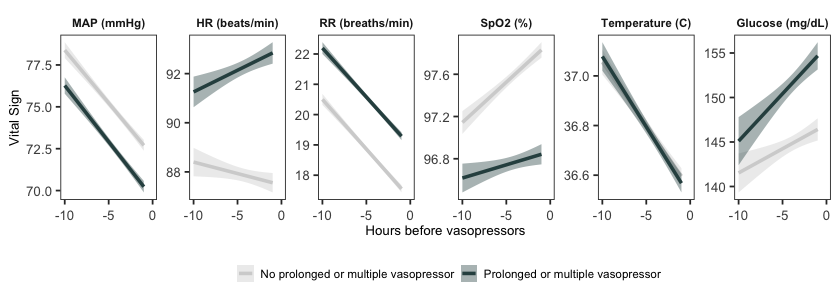

In [94]:
options(repr.plot.width=7, repr.plot.height=2.5)

p <- toplot %>%
    ggplot(aes(x=INTERVAL, y=VALUE, color=FANCY_RESPONSE)) +
        geom_smooth(method=lm, aes(fill=FANCY_RESPONSE)) + 
        xlab("Hours before vasopressors") + ylab("Vital Sign") +
        scale_x_continuous(limits=c(-10,0), breaks=seq(-10,0,5)) +
        base_theme() + 
        scale_color_manual(values=PRESSORHOURS_COLORS)+
        scale_fill_manual(values=PRESSORHOURS_COLORS)+
        theme(legend.title = element_blank()) +
        theme(legend.position="bottom") +
        facet_wrap(. ~ FANCY_VITAL, scale="free", nrow=1)
plot(p)

In [95]:
pdf(file.path(PLOT_DIR, "ancova_vitals.pdf"), 7,2.5)
plot(p)
dev.off()

pdf 
  2

Pressors by type

In [96]:
pressor_choices

[1] "norepinephrinedurations" "dopaminedurations"      
[3] "phenylephrinedurations"  "vasopressindurations"   
[5] "epinephrinedurations"

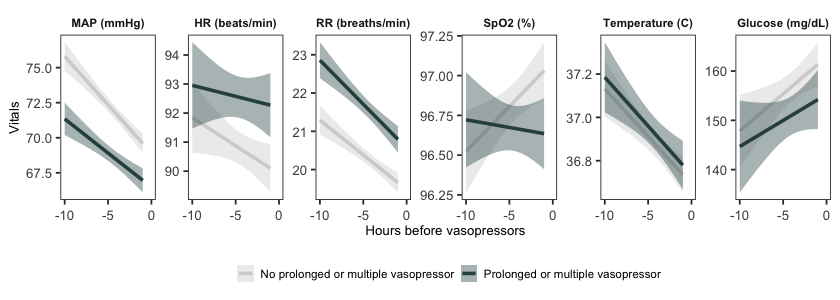

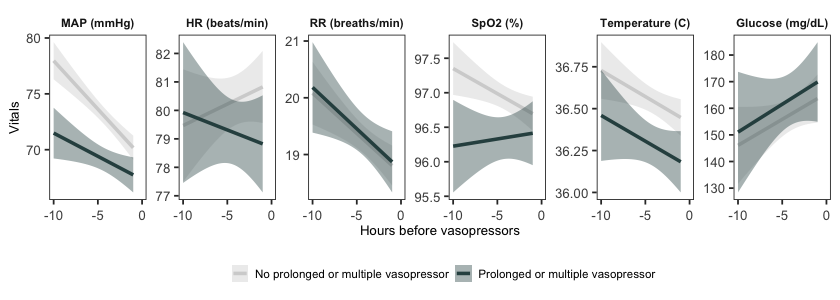

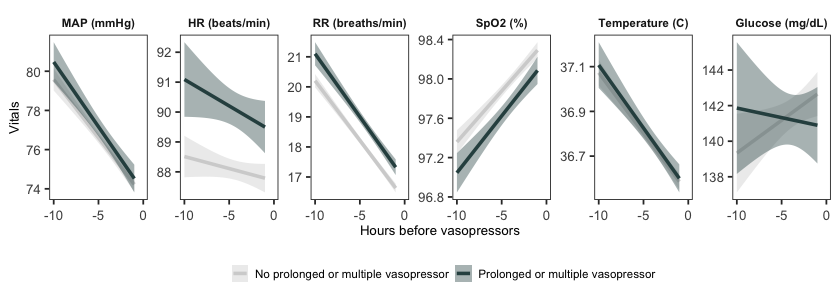

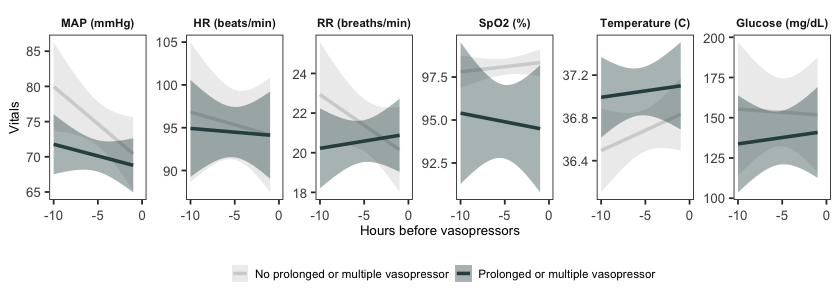

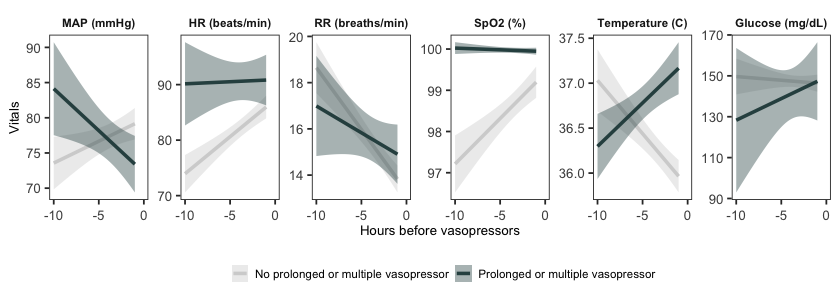

In [97]:
options(repr.plot.width=7, repr.plot.height=2.5)
for(pressor_choice in pressor_choices){
    toplot <- melt_results_df %>%
        filter(!grepl(",", pressor)) %>%
        mutate(INTERVAL = -INTERVAL) %>%
        drop_na(VALUE) %>%
        filter(pressor == pressor_choice, grepl("mean_", ID), ID != "mean_diasbp", ID != "mean_sysbp") %>%
        rowwise() %>%
        mutate(ID = as.character(ID)) %>%
        mutate(FANCY_VITAL = FANCY_VITAL_DICT[ID]) %>%
        mutate(FANCY_VITAL = factor(FANCY_VITAL, levels=FANCY_VITAL_ORDER)) %>%
        mutate(FANCY_RESPONSE = if(RESPONSE){"Prolonged or multiple vasopressor"}else{"No prolonged or multiple vasopressor"})

    p <- ggplot(toplot, aes(x=INTERVAL, y=VALUE, color=FANCY_RESPONSE)) +
        geom_smooth(method=lm, aes(fill=FANCY_RESPONSE)) + 
        xlab("Hours before vasopressors") + ylab("Vitals") +
        scale_x_continuous(limits=c(-10,0), breaks=seq(-10,0,5)) +
        base_theme() + 
        scale_color_manual(values=PRESSORHOURS_COLORS)+
        scale_fill_manual(values=PRESSORHOURS_COLORS)+
        theme(legend.title = element_blank()) +
        theme(legend.position="bottom") +
        facet_wrap(. ~ FANCY_VITAL, scale="free", nrow=1)
    
#     if(pressor_choice == 'phenylephrinedurations'){
#         p <- p + theme(legend.position="bottom")
#     }
    
    plot(p)
    
    pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_ancova_vitals.pdf")), 7,2.5)
    plot(p)
    dev.off()
}

# LR Summary

In [137]:
set.seed(100)

In [ ]:
lr_summary_list <- list()

In [138]:
LR_CATEGORICAL_COEFFICIENT_DICT <- c(
'genderM' = "Male Gender",
'intubTRUE' = "Intubated",
'simple_diagnosisINFECTION' = "Infectious Diagnosis",   
'simple_diagnosisOTHER DIAGNOSIS' = "Other Diagnosis",
'pressorphenylephrinedurations' = 'phenylephrine',
'pressornorepinephrinedurations' = 'norepinephrine',
'first_careunitCSRU' = 'CSRU',
'first_careunitSICU' = 'SICU',
'first_careunitMICU' = 'MICU',
'first_careunitTSICU' = 'TSICU'
)

LR_CONTINUOUS_COEFFICIENT_DICT <- c(
'age_cohort' = 'Age',
'mean_meanbp' = 'MAP',
'mean_resprate' = 'RR',
'mean_heartrate' = 'HR',
'mean_tempc' = 'Temperature',
'mean_spo2' = 'SpO2',
'mean_glucose' = 'Glucose'
)

In [141]:
LR_SEVERITY_COEFFICIENT_DICT <- c(
'sofa' = 'SOFA',
'oasis' = 'OASIS')

### ROC curve with CI

In [142]:
roc_with_ci <- function(obj) {
  ciobj <- ci.se(obj, specificities = seq(0, 1, l = 25))
  dat.ci <- data.frame(x = as.numeric(rownames(ciobj)),
                       lower = ciobj[, 1],
                       upper = ciobj[, 3])
  
  ggroc(obj) +
    base_theme() +
    theme(axis.title=element_text(size=10)) +
    geom_abline(
      slope = 1,
      intercept = 1,
      linetype = "dashed",
      alpha = 0.7,
      color = '#2F4F4F'
    ) + coord_equal() +
    geom_ribbon(
      data = dat.ci,
      aes(x = x, ymin = lower, ymax = upper),
      fill = '#2F4F4F',
      alpha = 0.2
    ) 
} 

# LR Model for Total
- Ran into problems with missing data for glucose, spo2 and tempc, hence the selection of criteria as variables

In [143]:
model_input_df <- melt_results_df %>%
    filter(INTERVAL == 1) %>%
    select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = ID, COURSE = course_id) %>%
    #mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            select(-pressor) %>%
            select(RESPONSE, course_id, first_careunit, cvc, intub, simple_race, simple_diagnosis, gender, age_cohort, sofa, oasis) %>%
            gather(VARIABLE, VALUE, -RESPONSE, -course_id) %>%
            rename(COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE) %>%
    rowwise() %>%
    mutate_at(vars(contains("mean_")), as.numeric, na.rm = TRUE) %>%
    mutate_at(vars(contains("median_")), as.numeric, na.rm = TRUE) %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE,
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
             oasis, sofa, 
             contains("mean_meanbp"),
             contains("mean_resprate"),
             contains("mean_heartrate") ,
             contains("mean_tempc"),
             contains("mean_spo2"),
             contains("mean_glucose")
              ) %>%
    mutate(sofa = as.numeric(sofa), oasis = as.numeric(oasis))

Warning message:
“attributes are not identical across measure variables;
they will be dropped”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

In [144]:
dim(model_input_df) %>% print()

[1] 15014    14


In [145]:
head(model_input_df)

RESPONSE,first_careunit,intub,simple_diagnosis,age_cohort,gender,oasis,sofa,mean_meanbp,mean_resprate,mean_heartrate,mean_tempc,mean_spo2,mean_glucose
<lgl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,CSRU,TRUE,CARDIAC,50,M,30,3,75.33333,19.5,96.0,37.13333,100.00,118
FALSE,MICU,FALSE,INFECTION,50,M,25,7,NA,NA,NA,NA,NA,NA
FALSE,SICU,TRUE,OTHER DIAGNOSIS,70,M,24,1,89.00000,26.0,118.0,NA,96.00,NA
FALSE,MICU,TRUE,INFECTION,80,F,45,8,70.00000,23.0,83.5,36.50000,97.00,NA
FALSE,CSRU,TRUE,OTHER DIAGNOSIS,70,M,31,3,68.20000,19.2,100.0,38.30000,99.75,102
FALSE,CSRU,TRUE,CARDIAC,70,F,31,3,NA,14.0,NA,NA,NA,NA


In [146]:
# exclude missing cases (done automatically by glm but this allows some more fine control)
model_input_cleaned_df <- model_input_df[which(complete.cases(model_input_df)),]

In [147]:
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_cleaned_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])


all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=learn)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}

p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
#plot(p_out, print.auc=TRUE)

Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


In [148]:
car::vif(model)

,GVIF,Df,GVIF^(1/(2*Df))
first_careunit,1.957311,4,1.087571
intub,1.234317,1,1.110998
simple_diagnosis,1.485316,2,1.103964
age_cohort,1.160727,1,1.077370
gender,1.058226,1,1.028701
oasis,1.497738,1,1.223821
sofa,1.337938,1,1.156693
mean_meanbp,1.087861,1,1.043006
mean_resprate,1.464625,1,1.210217
mean_heartrate,1.217502,1,1.103405


In [149]:
lr_summary_list[['TOTAL']] <- data.frame(MEAN_AUC = mean(aucs), 
                                         SD_AUC = sd(aucs), 
                                         MEAN_ACC = mean(all.acc), 
                                         SD_ACC = sd(all.acc))
lr_summary_list[['TOTAL']] 

MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<dbl>,<dbl>,<dbl>,<dbl>
0.6867299,0.02239433,0.6448846,0.01925385


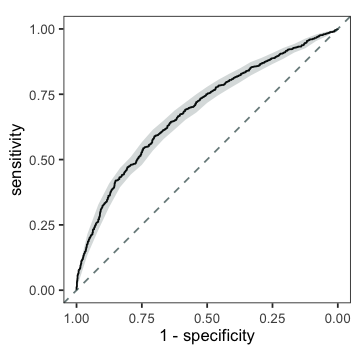

In [155]:
options(repr.plot.width=3, repr.plot.height=3)
p <- roc_with_ci(p_out) + xlab("1 - specificity")

plot(p)

In [156]:
pdf(file.path(PLOT_DIR, paste0("modelauc.pdf")), 3,3)
plot(p)
dev.off()

pdf 
  2

In [157]:
# imputation: 30 mins
model_input_imputed_df <- 
    rfImpute(RESPONSE ~ . , family=binomial(link='logit'), data=model_input_df %>% select(contains("mean"), RESPONSE)) %>%
    cbind(model_input_df %>% select(-contains("mean"), -RESPONSE))

Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2485    99.50 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2498   100.01 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2499   100.03 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2503   100.18 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2517   100.75 |


In [158]:
dim(model_input_df)

[1] 15014    14

In [159]:
dim(model_input_df)

[1] 15014    14

In [160]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_imputed_df)

#### Model parameter significance

In [161]:
summary(model)


Call:
glm(formula = RESPONSE ~ ., family = binomial(link = "logit"), 
    data = model_input_imputed_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5512  -1.0503   0.4658   1.0798   2.0790  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      2.346e+00  1.025e+00   2.289 0.022051 *  
mean_meanbp                     -5.614e-03  1.427e-03  -3.933 8.39e-05 ***
mean_resprate                    7.103e-03  4.096e-03   1.734 0.082924 .  
mean_heartrate                   8.779e-03  1.224e-03   7.171 7.45e-13 ***
mean_tempc                      -7.513e-02  2.391e-02  -3.143 0.001674 ** 
mean_spo2                       -1.427e-02  5.080e-03  -2.809 0.004964 ** 
mean_glucose                     3.793e-05  4.034e-04   0.094 0.925100    
first_careunitCSRU              -5.236e-01  6.135e-02  -8.534  < 2e-16 ***
first_careunitMICU              -2.442e-01  6.472e-02  -3.773 0.000161 ***
first_careunitS

In [162]:
summary(model)$coefficients %>% data.frame() %>% 
    tibble::rownames_to_column("Variable") %>%
    rename(P.Value = Pr...z..) %>% 
    mutate(SIGNIFICANT = P.Value < 0.05) %>% 
    write.csv(file.path(PLOT_DIR, "modelestimates.csv"))

In [163]:
oddsratio <- exp(cbind(coef(model), confint(model)))  %>% data.frame() 

Waiting for profiling to be done...


In [164]:
oddsratio_categorical <- oddsratio  %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CATEGORICAL_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CATEGORICAL_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CATEGORICAL_COEFFICIENT_DICT)))

oddsratio_categorical %>% write.csv(file.path(PLOT_DIR, "categoricalmodeleodds.csv"))

In [71]:
read.csv(file.path(PLOT_DIR, "categoricalmodeleodds.csv"))

X,factor,estimate,lower,upper,significant,legend
<int>,<fct>,<dbl>,<dbl>,<dbl>,<lgl>,<fct>
1,CSRU,0.5923979,0.5252000,0.6680127,TRUE,Significant
2,MICU,0.7833268,0.6898902,0.8891299,TRUE,Significant
3,SICU,0.8544754,0.7398938,0.9866813,TRUE,Significant
4,TSICU,0.8213369,0.7014703,0.9615993,TRUE,Significant
5,Intubated,1.7740079,1.5906837,1.9790814,TRUE,Significant
6,Infectious Diagnosis,0.9558851,0.8249167,1.1077601,FALSE,Not Significant
7,Other Diagnosis,0.9212893,0.8379243,1.0128767,FALSE,Not Significant
8,Male Gender,0.9157713,0.8514032,0.9849792,TRUE,Significant


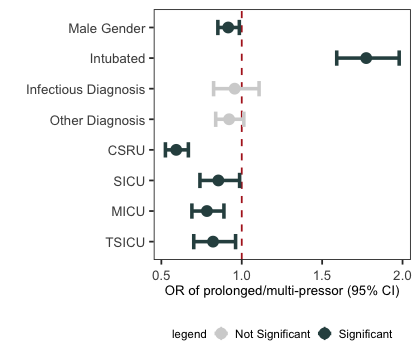

In [165]:
options(repr.plot.width=3.5, repr.plot.height=3)
p <- oddsratio_categorical %>% 
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("OR of prolonged/multi-pressor (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [166]:
pdf(file.path(PLOT_DIR, paste0("categoricalmodelodds.pdf")), 3.5,3)
plot(p)
dev.off()

pdf 
  2

In [167]:
oddsratio_continuous <- oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CONTINUOUS_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CONTINUOUS_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CONTINUOUS_COEFFICIENT_DICT)))

oddsratio_continuous %>% write.csv(file.path(PLOT_DIR, "continuousmodeleodds.csv"))

In [72]:
read.csv(file.path(PLOT_DIR, "continuousmodeleodds.csv"))

X,factor,estimate,lower,upper,significant,legend
<int>,<fct>,<dbl>,<dbl>,<dbl>,<lgl>,<fct>
1,MAP,0.9944019,0.9916206,0.9971854,TRUE,Significant
2,RR,1.0071279,0.9990806,1.0152546,FALSE,Not Significant
3,HR,1.0088181,1.0064041,1.0112461,TRUE,Significant
4,Temperature,0.9276230,0.8850928,0.9720667,TRUE,Significant
5,SpO2,0.9858293,0.9759456,0.9955836,TRUE,Significant
6,Glucose,1.0000379,0.9992501,1.0008318,FALSE,Not Significant
7,Age,1.0013673,0.9987403,1.0040013,FALSE,Not Significant


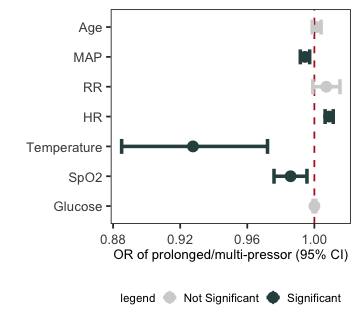

In [168]:
options(repr.plot.width=3, repr.plot.height=2.7)
p <- oddsratio_continuous %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("OR of prolonged/multi-pressor (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [169]:
pdf(file.path(PLOT_DIR, paste0("continuousmodelodds.pdf")), 3.1,2.7)
plot(p)
dev.off()

pdf 
  2

In [170]:
oddsratio_severity <-oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_SEVERITY_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_SEVERITY_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_SEVERITY_COEFFICIENT_DICT)))

oddsratio_severity %>% write.csv(file.path(PLOT_DIR, "severitymodeleodds.csv"))

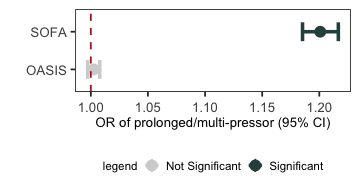

In [171]:
options(repr.plot.width=3, repr.plot.height=1.6)
p <- oddsratio_severity %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("OR of prolonged/multi-pressor (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [172]:
pdf(file.path(PLOT_DIR, paste0("severitymodelodds.pdf")), 3.1,1.6)
plot(p)
dev.off()

pdf 
  2

# LR Model for norepinephrine
- Running into problems with missing data for glucose, spo2 and tempc. 

In [173]:
pressor_choice <- 'norepinephrinedurations'

In [174]:
model_input_df <- melt_results_df %>%
    filter(grepl(pressor_choice, pressor), INTERVAL == 1) %>% select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = ID, COURSE = course_id) %>%
    #mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            filter(grepl(pressor_choice, pressor))  %>%
            select(-pressor) %>%
            select(RESPONSE, course_id, first_careunit, cvc, intub, simple_race, simple_diagnosis, gender, age_cohort, sofa, oasis) %>%
            gather(VARIABLE, VALUE, -RESPONSE, -course_id) %>%
            rename(COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE) %>%
    mutate_at(vars(contains("mean_")), as.numeric, na.rm = TRUE) %>%
    mutate_at(vars(contains("median_")), as.numeric, na.rm = TRUE) %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE, 
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
            sofa, oasis,
              contains("mean_meanbp"),
             contains("mean_resprate"),
             contains("mean_heartrate"),
             contains("mean_tempc"),
             contains("mean_spo2"),
             contains("mean_glucose")
              ) %>%
    mutate( sofa = as.numeric(sofa), oasis = as.numeric(oasis))

Warning message:
“attributes are not identical across measure variables;
they will be dropped”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

In [175]:
dim(model_input_df) %>% print()

[1] 6186   14


In [176]:
# exclude missing cases (done automatically by glm but this allows some more fine control)
model_input_cleaned_df <- model_input_df[which(complete.cases(model_input_df)),]

In [177]:
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_cleaned_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])


all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=learn)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}

p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
#plot(p_out, print.auc=TRUE)

Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


In [178]:
car::vif(model) %>% print()

                     GVIF Df GVIF^(1/(2*Df))
first_careunit   2.166256  4        1.101447
intub            1.412620  1        1.188537
simple_diagnosis 1.651976  2        1.133707
age_cohort       1.169564  1        1.081464
gender           1.097677  1        1.047701
sofa             1.381223  1        1.175254
oasis            1.674946  1        1.294197
mean_meanbp      1.191100  1        1.091375
mean_resprate    1.568564  1        1.252423
mean_heartrate   1.200345  1        1.095602
mean_tempc       1.231556  1        1.109755
mean_spo2        1.174989  1        1.083969
mean_glucose     1.095870  1        1.046838


In [179]:
lr_summary_list[[pressor_choice]] <- data.frame(MEAN_AUC = mean(aucs), 
                                         SD_AUC = sd(aucs), 
                                         MEAN_ACC = mean(all.acc), 
                                         SD_ACC = sd(all.acc))
lr_summary_list[[pressor_choice]] 

MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<dbl>,<dbl>,<dbl>,<dbl>
0.7083941,0.04155786,0.7470441,0.04261945


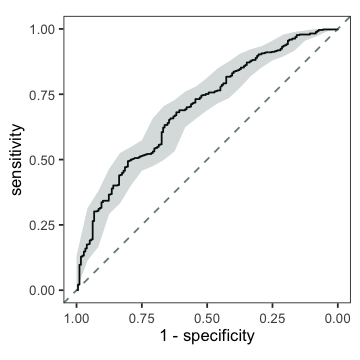

In [180]:
options(repr.plot.width=3, repr.plot.height=3)
p <- roc_with_ci(p_out) + xlab("1 - specificity")

plot(p)

In [181]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_modelauc.pdf")), 3,3)
plot(p)
dev.off()

pdf 
  2

In [182]:
# imputation: 30 mins
model_input_imputed_df <- 
    rfImpute(RESPONSE ~ . , family=binomial(link='logit'), data=model_input_df %>% select(contains("mean"), RESPONSE)) %>%
    cbind(model_input_df %>% select(-contains("mean"), -RESPONSE))

Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2006   100.90 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |      0.2   100.60 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2023   101.77 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2023   101.79 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2022   101.71 |


In [183]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_imputed_df)

In [184]:
summary(model) %>% print()


Call:
glm(formula = RESPONSE ~ ., family = binomial(link = "logit"), 
    data = model_input_imputed_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5322  -1.0067   0.6048   0.7872   1.7856  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      4.8954628  1.7092026   2.864  0.00418 ** 
mean_meanbp                     -0.0102751  0.0021940  -4.683 2.82e-06 ***
mean_resprate                    0.0009645  0.0065914   0.146  0.88366    
mean_heartrate                   0.0127364  0.0019307   6.597 4.20e-11 ***
mean_tempc                      -0.0621475  0.0389218  -1.597  0.11033    
mean_spo2                       -0.0323968  0.0086161  -3.760  0.00017 ***
mean_glucose                    -0.0010405  0.0006038  -1.723  0.08484 .  
first_careunitCSRU              -0.0498470  0.1244810  -0.400  0.68883    
first_careunitMICU              -0.4711278  0.1040901  -4.526 6.01e-06 ***
first_careunitS

In [185]:
# isolate out model coefficients
summary(model)$coefficients %>% data.frame() %>% 
    tibble::rownames_to_column("Variable") %>%
    rename(P.Value = Pr...z..) %>% 
    mutate(SIGNIFICANT = P.Value < 0.05) %>% 
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_modelestimates.csv")))

In [186]:
oddsratio <- exp(cbind(coef(model), confint(model)))

Waiting for profiling to be done...


In [187]:
oddsratio_categorical <- oddsratio  %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CATEGORICAL_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CATEGORICAL_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CATEGORICAL_COEFFICIENT_DICT)))

oddsratio_categorical %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodeleodds.csv")))

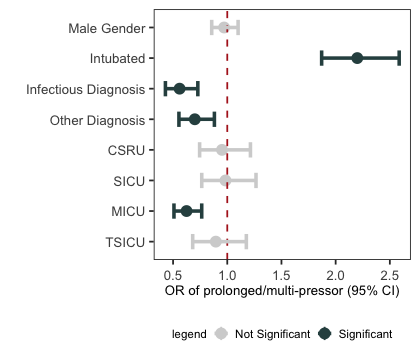

In [188]:
options(repr.plot.width=3.5, repr.plot.height=3)
p <- oddsratio_categorical %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("OR of prolonged/multi-pressor (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [189]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodelodds.pdf")), 3.5,3)
plot(p)
dev.off()

pdf 
  2

In [190]:
oddsratio_continuous <- oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CONTINUOUS_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CONTINUOUS_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CONTINUOUS_COEFFICIENT_DICT)))

oddsratio_continuous %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodeleodds.csv")))

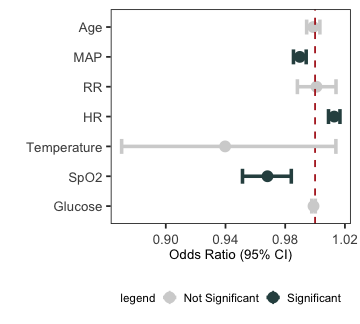

In [191]:
options(repr.plot.width=3, repr.plot.height=2.7)
p <- oddsratio_continuous %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [192]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodelodds.pdf")), 3.1,2.7)
plot(p)
dev.off()

pdf 
  2

In [193]:
oddsratio_severity <-oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_SEVERITY_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_SEVERITY_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_SEVERITY_COEFFICIENT_DICT)))

oddsratio_severity %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_severitymodelodds.csv")))

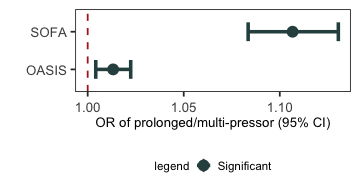

In [194]:
options(repr.plot.width=3, repr.plot.height=1.6)
p <- oddsratio_severity %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("OR of prolonged/multi-pressor (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [195]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_severitymodelodds.pdf")), 3.1,1.6)
plot(p)
dev.off()

pdf 
  2

# LR Model for dopamine
- Running into problems with missing data for glucose, spo2 and tempc. 

In [196]:
pressor_choice <- 'dopaminedurations'

In [197]:
model_input_df <- melt_results_df %>%
    filter(grepl(pressor_choice, pressor), INTERVAL == 1) %>% select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = ID, COURSE = course_id) %>%
    #mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            filter(grepl(pressor_choice, pressor))  %>%
            select(-pressor) %>%
            select(RESPONSE, course_id, first_careunit, cvc, intub, simple_race, simple_diagnosis, gender, age_cohort, sofa, oasis) %>%
            gather(VARIABLE, VALUE, -RESPONSE, -course_id) %>%
            rename(COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE) %>%
    mutate_at(vars(contains("mean_")), as.numeric, na.rm = TRUE) %>%
    mutate_at(vars(contains("median_")), as.numeric, na.rm = TRUE) %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE, 
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
             sofa, oasis,
              contains("mean_meanbp"),
             contains("mean_resprate"),
             contains("mean_heartrate"),
             contains("mean_tempc"),
             contains("mean_spo2"),
             contains("mean_glucose")
              ) %>%
    mutate(sofa = as.numeric(sofa), oasis = as.numeric(oasis))

Warning message:
“attributes are not identical across measure variables;
they will be dropped”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

In [198]:
dim(model_input_df) %>% print()

[1] 2698   14


In [199]:
# exclude missing cases (done automatically by glm but this allows some more fine control)
model_input_cleaned_df <- model_input_df[which(complete.cases(model_input_df)),]

In [200]:
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_cleaned_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])


all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=learn)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}

p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
#plot(p_out, print.auc=TRUE)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Setting levels: control = FALSE, case = TRUE
Setting direction: controls > cases
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


In [201]:
car::vif(model) %>% print()

                     GVIF Df GVIF^(1/(2*Df))
first_careunit   2.296762  4        1.109531
intub            1.837630  1        1.355592
simple_diagnosis 1.314745  2        1.070805
age_cohort       1.427926  1        1.194958
gender           1.271224  1        1.127485
sofa             1.746287  1        1.321471
oasis            1.857554  1        1.362921
mean_meanbp      1.270586  1        1.127203
mean_resprate    1.713221  1        1.308901
mean_heartrate   1.441315  1        1.200548
mean_tempc       1.359545  1        1.165995
mean_spo2        1.333176  1        1.154632
mean_glucose     1.523158  1        1.234163


In [202]:
lr_summary_list[[pressor_choice]] <- data.frame(MEAN_AUC = mean(aucs), 
                                         SD_AUC = sd(aucs), 
                                         MEAN_ACC = mean(all.acc), 
                                         SD_ACC = sd(all.acc))
lr_summary_list[[pressor_choice]] 

MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<dbl>,<dbl>,<dbl>,<dbl>
0.7146886,0.1654161,0.8233333,0.03044906


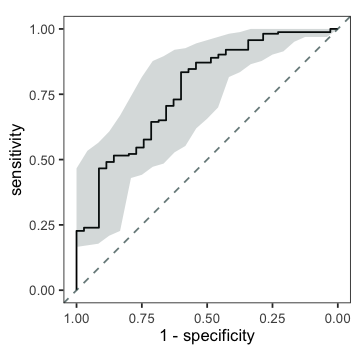

In [203]:
options(repr.plot.width=3, repr.plot.height=3)
p <- roc_with_ci(p_out) + xlab("1 - specificity")

plot(p)

In [204]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_modelauc.pdf")), 3,3)
plot(p)
dev.off()

pdf 
  2

In [205]:
# imputation: 30 mins
model_input_imputed_df <- 
    rfImpute(RESPONSE ~ . , family=binomial(link='logit'), data=model_input_df %>% select(contains("mean"), RESPONSE)) %>%
    cbind(model_input_df %>% select(-contains("mean"), -RESPONSE))

Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2185   101.47 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2171   100.79 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2198   102.04 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2202   102.25 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2217   102.91 |


In [206]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_imputed_df)

In [207]:
summary(model) %>% print()


Call:
glm(formula = RESPONSE ~ ., family = binomial(link = "logit"), 
    data = model_input_imputed_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5643  -0.9016   0.5212   0.7955   1.9441  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -0.6575490  2.8534897  -0.230 0.817752    
mean_meanbp                     -0.0138384  0.0035647  -3.882 0.000104 ***
mean_resprate                    0.0114594  0.0114439   1.001 0.316656    
mean_heartrate                   0.0123936  0.0031938   3.881 0.000104 ***
mean_tempc                      -0.0311694  0.0692491  -0.450 0.652634    
mean_spo2                       -0.0033082  0.0108856  -0.304 0.761199    
mean_glucose                     0.0001815  0.0008867   0.205 0.837790    
first_careunitCSRU               0.9043333  0.1868529   4.840  1.3e-06 ***
first_careunitMICU               0.1511447  0.1179342   1.282 0.199982    
first_careunitS

In [208]:
# isolate out model coefficients
summary(model)$coefficients %>% data.frame() %>% 
    tibble::rownames_to_column("Variable") %>%
    rename(P.Value = Pr...z..) %>% 
    mutate(SIGNIFICANT = P.Value < 0.05) %>% 
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_modelestimates.csv")))

In [209]:
oddsratio <- exp(cbind(coef(model), confint(model)))

Waiting for profiling to be done...


In [210]:
oddsratio_categorical <- oddsratio %>% data.frame()  %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CATEGORICAL_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CATEGORICAL_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CATEGORICAL_COEFFICIENT_DICT)))

oddsratio_categorical %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodeleodds.csv")))

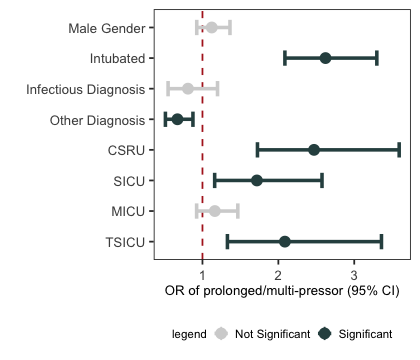

In [211]:
options(repr.plot.width=3.5, repr.plot.height=3)
p <- oddsratio_categorical %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("OR of prolonged/multi-pressor (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [212]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodelodds.pdf")), 3.5,3)
plot(p)
dev.off()

pdf 
  2

In [213]:
oddsratio_continuous <-oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CONTINUOUS_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CONTINUOUS_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CONTINUOUS_COEFFICIENT_DICT)))

oddsratio_continuous %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodeleodds.csv")))

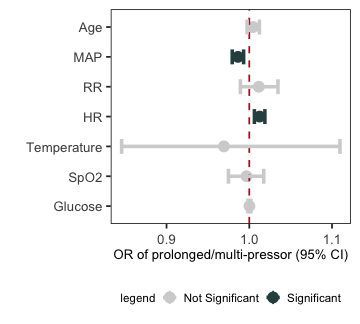

In [214]:
options(repr.plot.width=3, repr.plot.height=2.7)
p <- oddsratio_continuous %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("OR of prolonged/multi-pressor (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [215]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodelodds.pdf")), 3.1,2.7)
plot(p)
dev.off()

pdf 
  2

In [216]:
oddsratio_severity <-oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_SEVERITY_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_SEVERITY_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_SEVERITY_COEFFICIENT_DICT)))

oddsratio_severity %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_severitymodelodds.csv")))

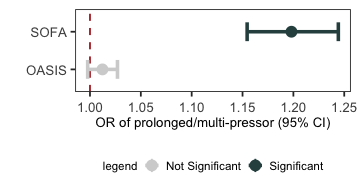

In [217]:
options(repr.plot.width=3, repr.plot.height=1.6)
p <- oddsratio_severity %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("OR of prolonged/multi-pressor (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [218]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_severitymodelodds.pdf")), 3.1,1.6)
plot(p)
dev.off()

pdf 
  2

# LR Model for phenylephrine
- Running into problems with missing data for glucose, spo2 and tempc. 

In [219]:
pressor_choice <- 'phenylephrinedurations'

In [220]:
model_input_df <- melt_results_df %>%
    filter(grepl(pressor_choice, pressor), INTERVAL == 1) %>% select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = ID, COURSE = course_id) %>%
    #mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            filter(grepl(pressor_choice, pressor))  %>%
            select(-pressor) %>%
            select(RESPONSE, course_id, first_careunit, cvc, intub, simple_race, simple_diagnosis, gender, age_cohort, sofa, oasis) %>%
            gather(VARIABLE, VALUE, -RESPONSE, -course_id) %>%
            rename(COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE) %>%
    mutate_at(vars(contains("mean_")), as.numeric, na.rm = TRUE) %>%
    mutate_at(vars(contains("median_")), as.numeric, na.rm = TRUE) %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE, 
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
             sofa, oasis,
              contains("mean_meanbp"),
             contains("mean_resprate"),
             contains("mean_heartrate"),
             contains("mean_tempc"),
             contains("mean_spo2"),
             contains("mean_glucose")
              ) %>%
    mutate(sofa = as.numeric(sofa), oasis = as.numeric(oasis))

Warning message:
“attributes are not identical across measure variables;
they will be dropped”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

In [221]:
dim(model_input_df) %>% print()

[1] 9505   14


In [222]:
# exclude missing cases (done automatically by glm but this allows some more fine control)
model_input_cleaned_df <- model_input_df[which(complete.cases(model_input_df)),]

In [223]:
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_cleaned_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])


all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=learn)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}

p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
#plot(p_out, print.auc=TRUE)

Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


In [224]:
car::vif(model) %>% print()

                     GVIF Df GVIF^(1/(2*Df))
first_careunit   1.727809  4        1.070747
intub            1.142502  1        1.068879
simple_diagnosis 1.282193  2        1.064114
age_cohort       1.160147  1        1.077101
gender           1.051720  1        1.025534
sofa             1.274290  1        1.128845
oasis            1.399820  1        1.183140
mean_meanbp      1.097254  1        1.047499
mean_resprate    1.335269  1        1.155539
mean_heartrate   1.282663  1        1.132547
mean_tempc       1.231428  1        1.109697
mean_spo2        1.199257  1        1.095106
mean_glucose     1.083882  1        1.041097


In [225]:
lr_summary_list[[pressor_choice]] <- data.frame(MEAN_AUC = mean(aucs), 
                                         SD_AUC = sd(aucs), 
                                         MEAN_ACC = mean(all.acc), 
                                         SD_ACC = sd(all.acc))
lr_summary_list[[pressor_choice]] 

MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<dbl>,<dbl>,<dbl>,<dbl>
0.7104567,0.01869009,0.6610513,0.01058284


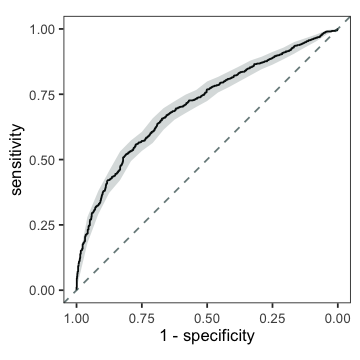

In [226]:
options(repr.plot.width=3, repr.plot.height=3)
p <- roc_with_ci(p_out) + xlab("1 - specificity")

plot(p)

In [227]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_modelauc.pdf")), 3,3)
plot(p)
dev.off()

pdf 
  2

In [228]:
# imputation: 30 mins
model_input_imputed_df <- 
    rfImpute(RESPONSE ~ . , family=binomial(link='logit'), data=model_input_df %>% select(contains("mean"), RESPONSE)) %>%
    cbind(model_input_df %>% select(-contains("mean"), -RESPONSE))

Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2453    98.33 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2453    98.33 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2479    99.37 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2462    98.69 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2487    99.68 |


In [229]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_imputed_df)

In [230]:
summary(model) %>% print()


Call:
glm(formula = RESPONSE ~ ., family = binomial(link = "logit"), 
    data = model_input_imputed_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7915  -0.9971   0.2974   1.0285   1.9304  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      2.550e+00  1.488e+00   1.714 0.086540 .  
mean_meanbp                      2.627e-05  1.948e-03   0.013 0.989242    
mean_resprate                    8.356e-03  5.518e-03   1.514 0.129924    
mean_heartrate                   4.804e-03  1.665e-03   2.886 0.003908 ** 
mean_tempc                      -6.043e-02  3.248e-02  -1.861 0.062779 .  
mean_spo2                       -1.764e-02  8.132e-03  -2.170 0.030028 *  
mean_glucose                     1.892e-03  6.327e-04   2.991 0.002785 ** 
first_careunitCSRU              -9.991e-01  9.059e-02 -11.029  < 2e-16 ***
first_careunitMICU              -2.917e-01  1.086e-01  -2.686 0.007230 ** 
first_careunitS

In [231]:
# isolate out model coefficients
summary(model)$coefficients %>% data.frame() %>% 
    tibble::rownames_to_column("Variable") %>%
    rename(P.Value = Pr...z..) %>% 
    mutate(SIGNIFICANT = P.Value < 0.05) %>% 
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_modelestimates.csv")))

In [232]:
oddsratio <- exp(cbind(coef(model), confint(model)))

Waiting for profiling to be done...


In [233]:
oddsratio_categorical <- oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CATEGORICAL_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CATEGORICAL_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CATEGORICAL_COEFFICIENT_DICT)))

oddsratio_categorical %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodeleodds.csv")))

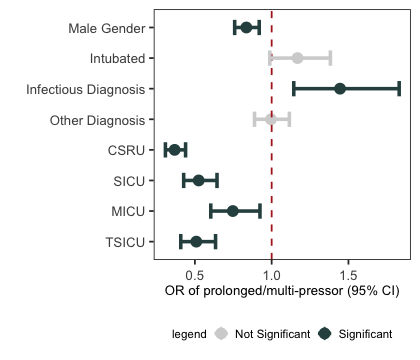

In [234]:
options(repr.plot.width=3.5, repr.plot.height=3)
p <- oddsratio_categorical %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("OR of prolonged/multi-pressor (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [235]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodelodds.pdf")), 3.5,3)
plot(p)
dev.off()

pdf 
  2

In [236]:
oddsratio_continuous <-oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CONTINUOUS_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CONTINUOUS_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CONTINUOUS_COEFFICIENT_DICT)))

oddsratio_continuous %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodeleodds.csv")))

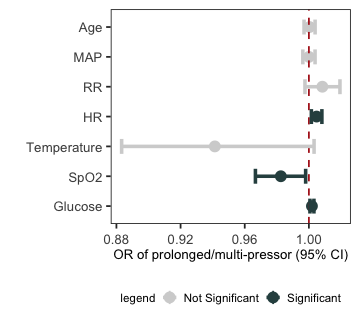

In [237]:
options(repr.plot.width=3, repr.plot.height=2.7)
p <- oddsratio_continuous %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("OR of prolonged/multi-pressor (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [238]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodelodds.pdf")), 3.1,2.7)
plot(p)
dev.off()

pdf 
  2

In [239]:
oddsratio_severity <-oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_SEVERITY_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_SEVERITY_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_SEVERITY_COEFFICIENT_DICT)))

oddsratio_severity %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_severitymodelodds.csv")))

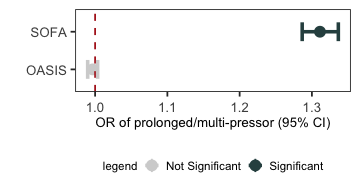

In [240]:
options(repr.plot.width=3, repr.plot.height=1.6)
p <- oddsratio_severity %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("OR of prolonged/multi-pressor (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [241]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_severitymodelodds.pdf")), 3.1,1.6)
plot(p)
dev.off()

pdf 
  2

# Output AUC table

In [242]:
auc_output_df <- bind_rows(lr_summary_list, .id="PRESSOR")
auc_output_df 

PRESSOR,MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
TOTAL,0.6867299,0.02239433,0.6448846,0.01925385
norepinephrinedurations,0.7083941,0.04155786,0.7470441,0.04261945
dopaminedurations,0.7146886,0.16541614,0.8233333,0.03044906
phenylephrinedurations,0.7104567,0.01869009,0.6610513,0.01058284


In [243]:
auc_output_df  %>% write.csv(file.path(PLOT_DIR, "summary_auc.csv"))